In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC


from textblob import TextBlob

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from mlxtend.frequent_patterns import apriori, association_rules

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# 设置绘图语言为中文
plt.rcParams['font.sans-serif'] = ['SimHei']
# 设置绘图风格为science
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})
# 设置绘图尺寸为（16，12），dpi为500，图片质量为最高，图片边缘留白为0，背景透明，字体大小最佳
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 500
# 绘图显示正负号
plt.rcParams['axes.unicode_minus'] = False


In [94]:


# 加载训练集
train_data = pd.read_csv('drugsComTrain_raw.csv')
print('训练集加载完成')

# 加载测试集
test_data = pd.read_csv('drugsComTest_raw.csv')
print('测试集加载完成')

# 显示训练集的前五行
train_data.head()

训练集加载完成
测试集加载完成


uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

In [95]:
# 查看训练集的形状
print('训练集的形状:', train_data.shape)

# 查看测试集的形状
print('测试集的形状:', test_data.shape)

# 检查训练集是否有缺失值
print('\n训练集缺失值情况:')
print(train_data.isnull().sum())

# 检查测试集是否有缺失值
print('\n测试集缺失值情况:')
print(test_data.isnull().sum())

# 查看训练集的统计摘要
print('\n训练集统计摘要:')
print(train_data.describe(include='all'))

# 查看测试集的统计摘要
print('\n测试集统计摘要:')
print(test_data.describe(include='all'))

训练集的形状: (161297, 7)
测试集的形状: (53766, 7)

训练集缺失值情况:
uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

测试集缺失值情况:
uniqueID         0
drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64

训练集统计摘要:
             uniqueID        drugName      condition  review         rating  \
count   161297.000000          161297         160398  161297  161297.000000   
unique            NaN            3436            884  112329            NaN   
top               NaN  Levonorgestrel  Birth Control  "Good"            NaN   
freq              NaN            3657          28788      33            NaN   
mean    115923.585305             NaN            NaN     NaN       6.994377   
std      67004.445170             NaN            NaN     NaN       3.272329   
min          2.000000             NaN            NaN     NaN       1.000000   
25%  

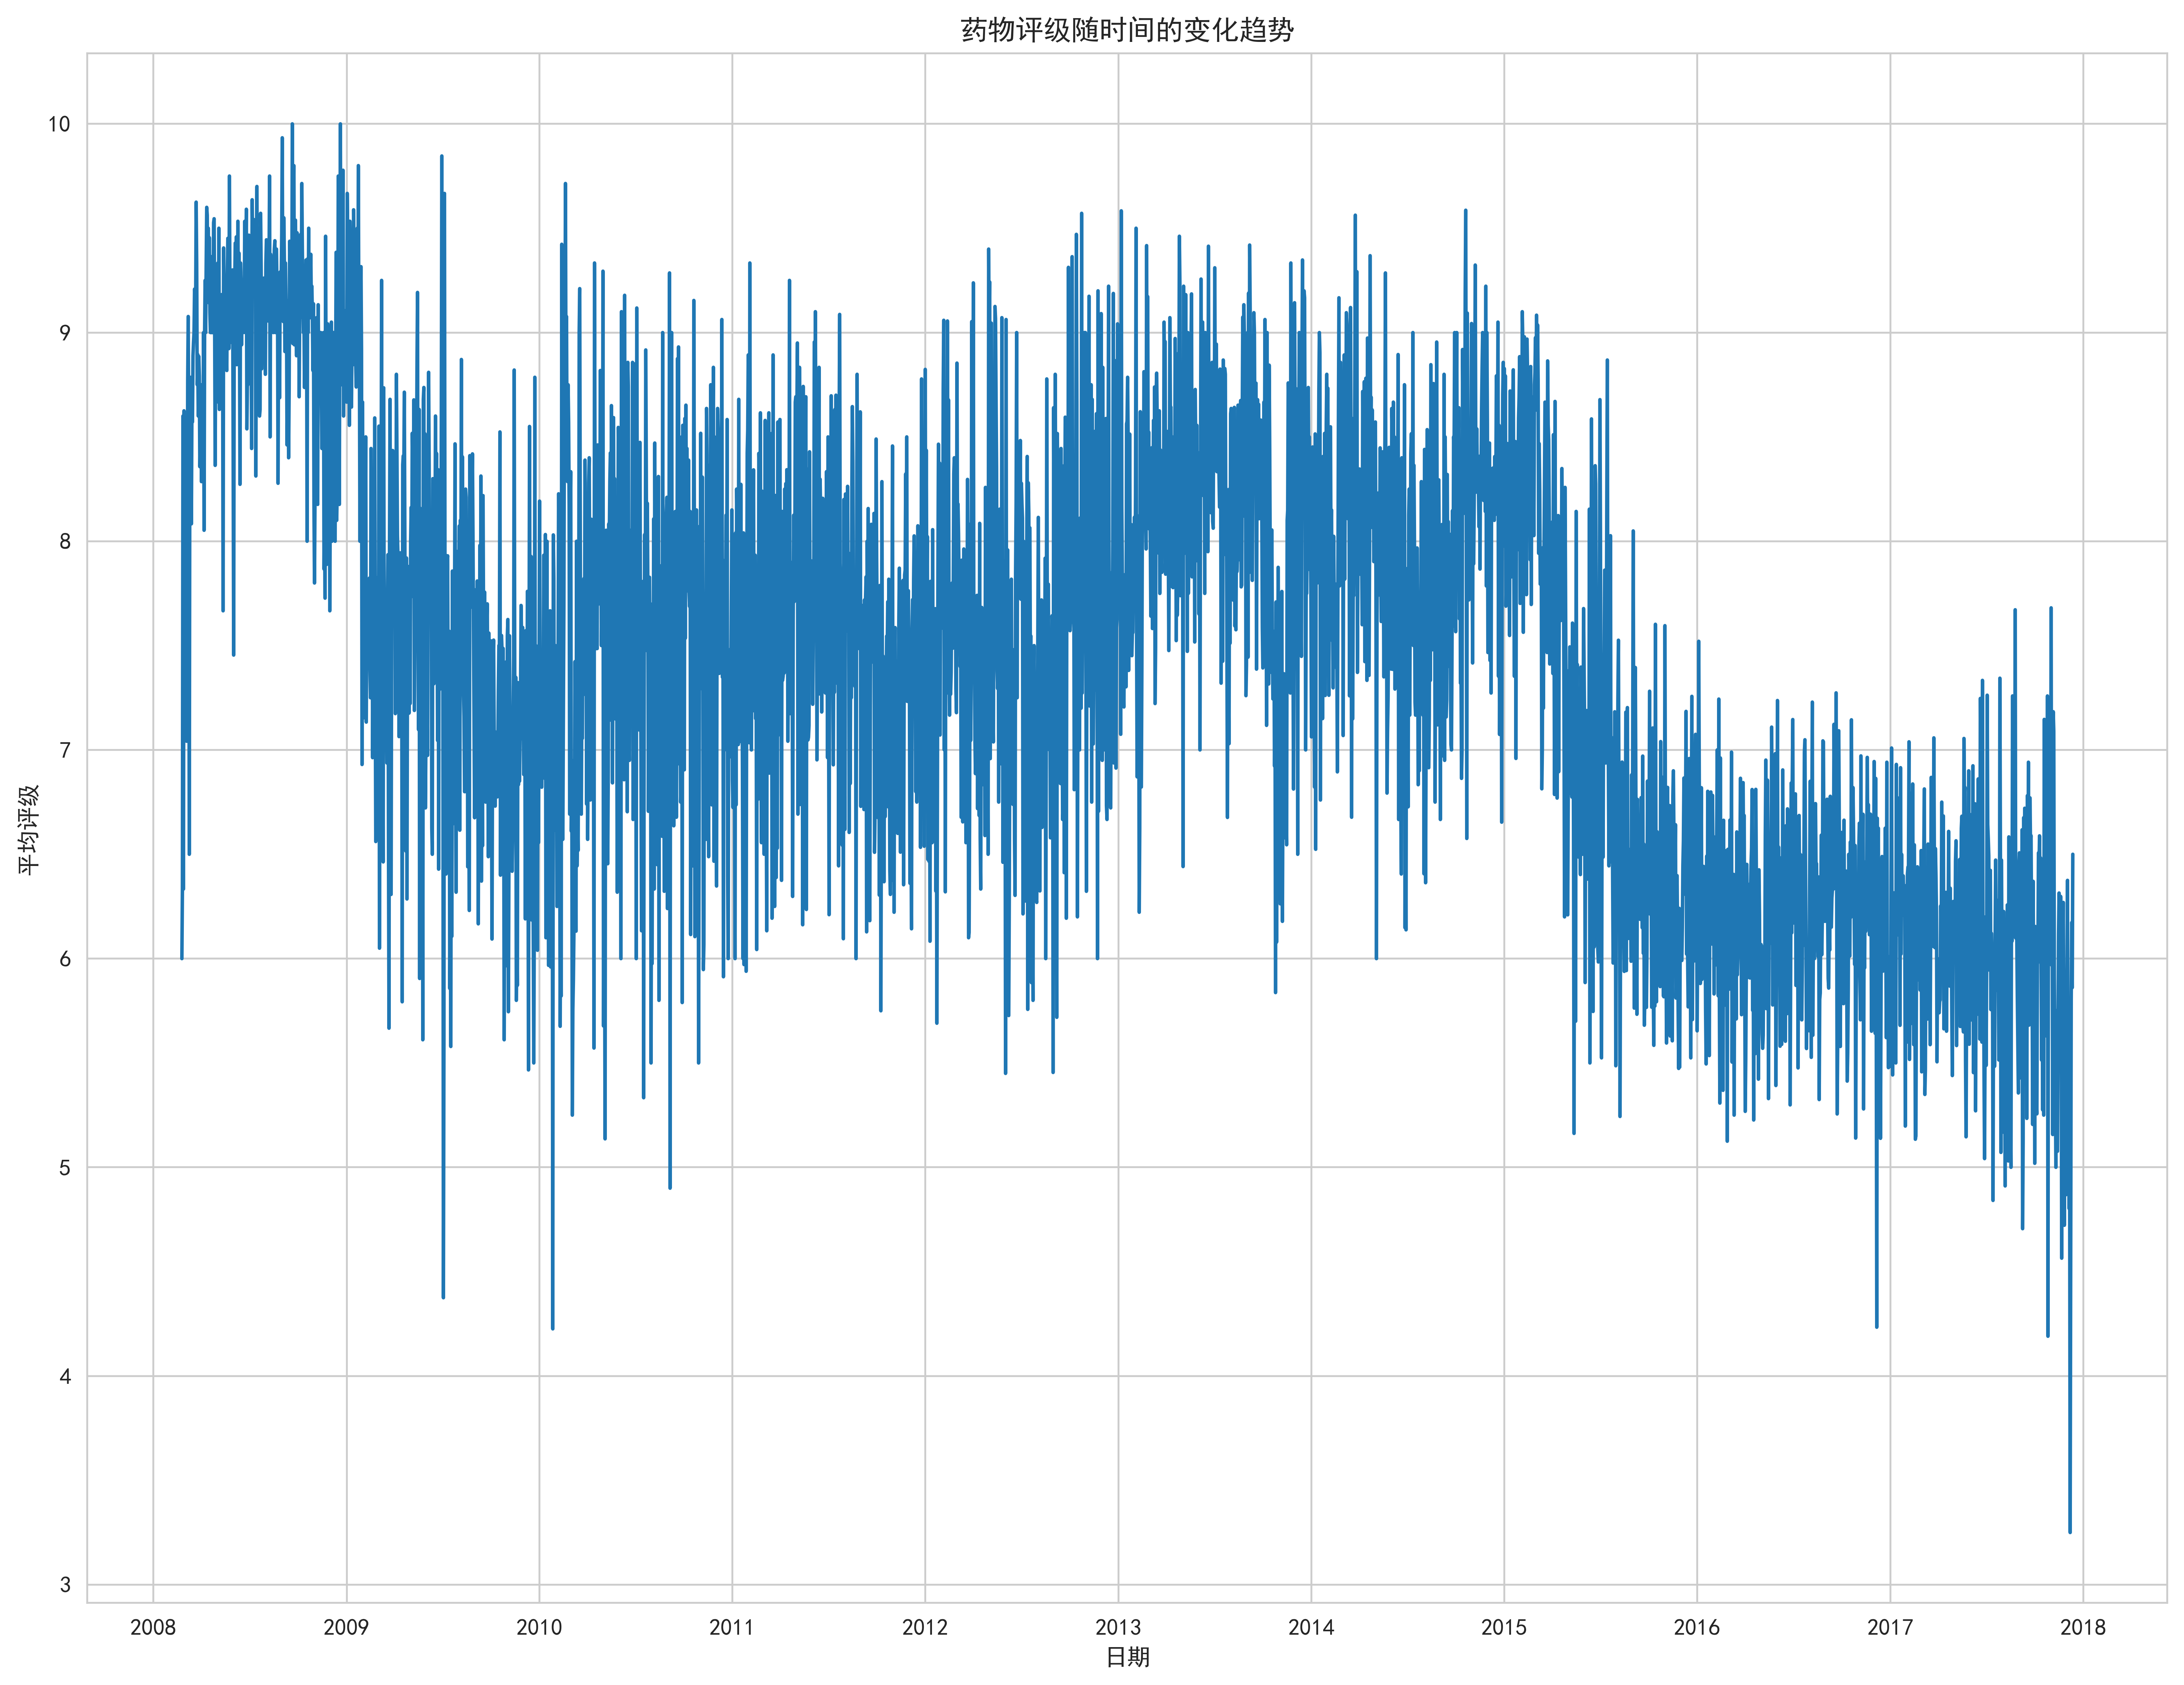

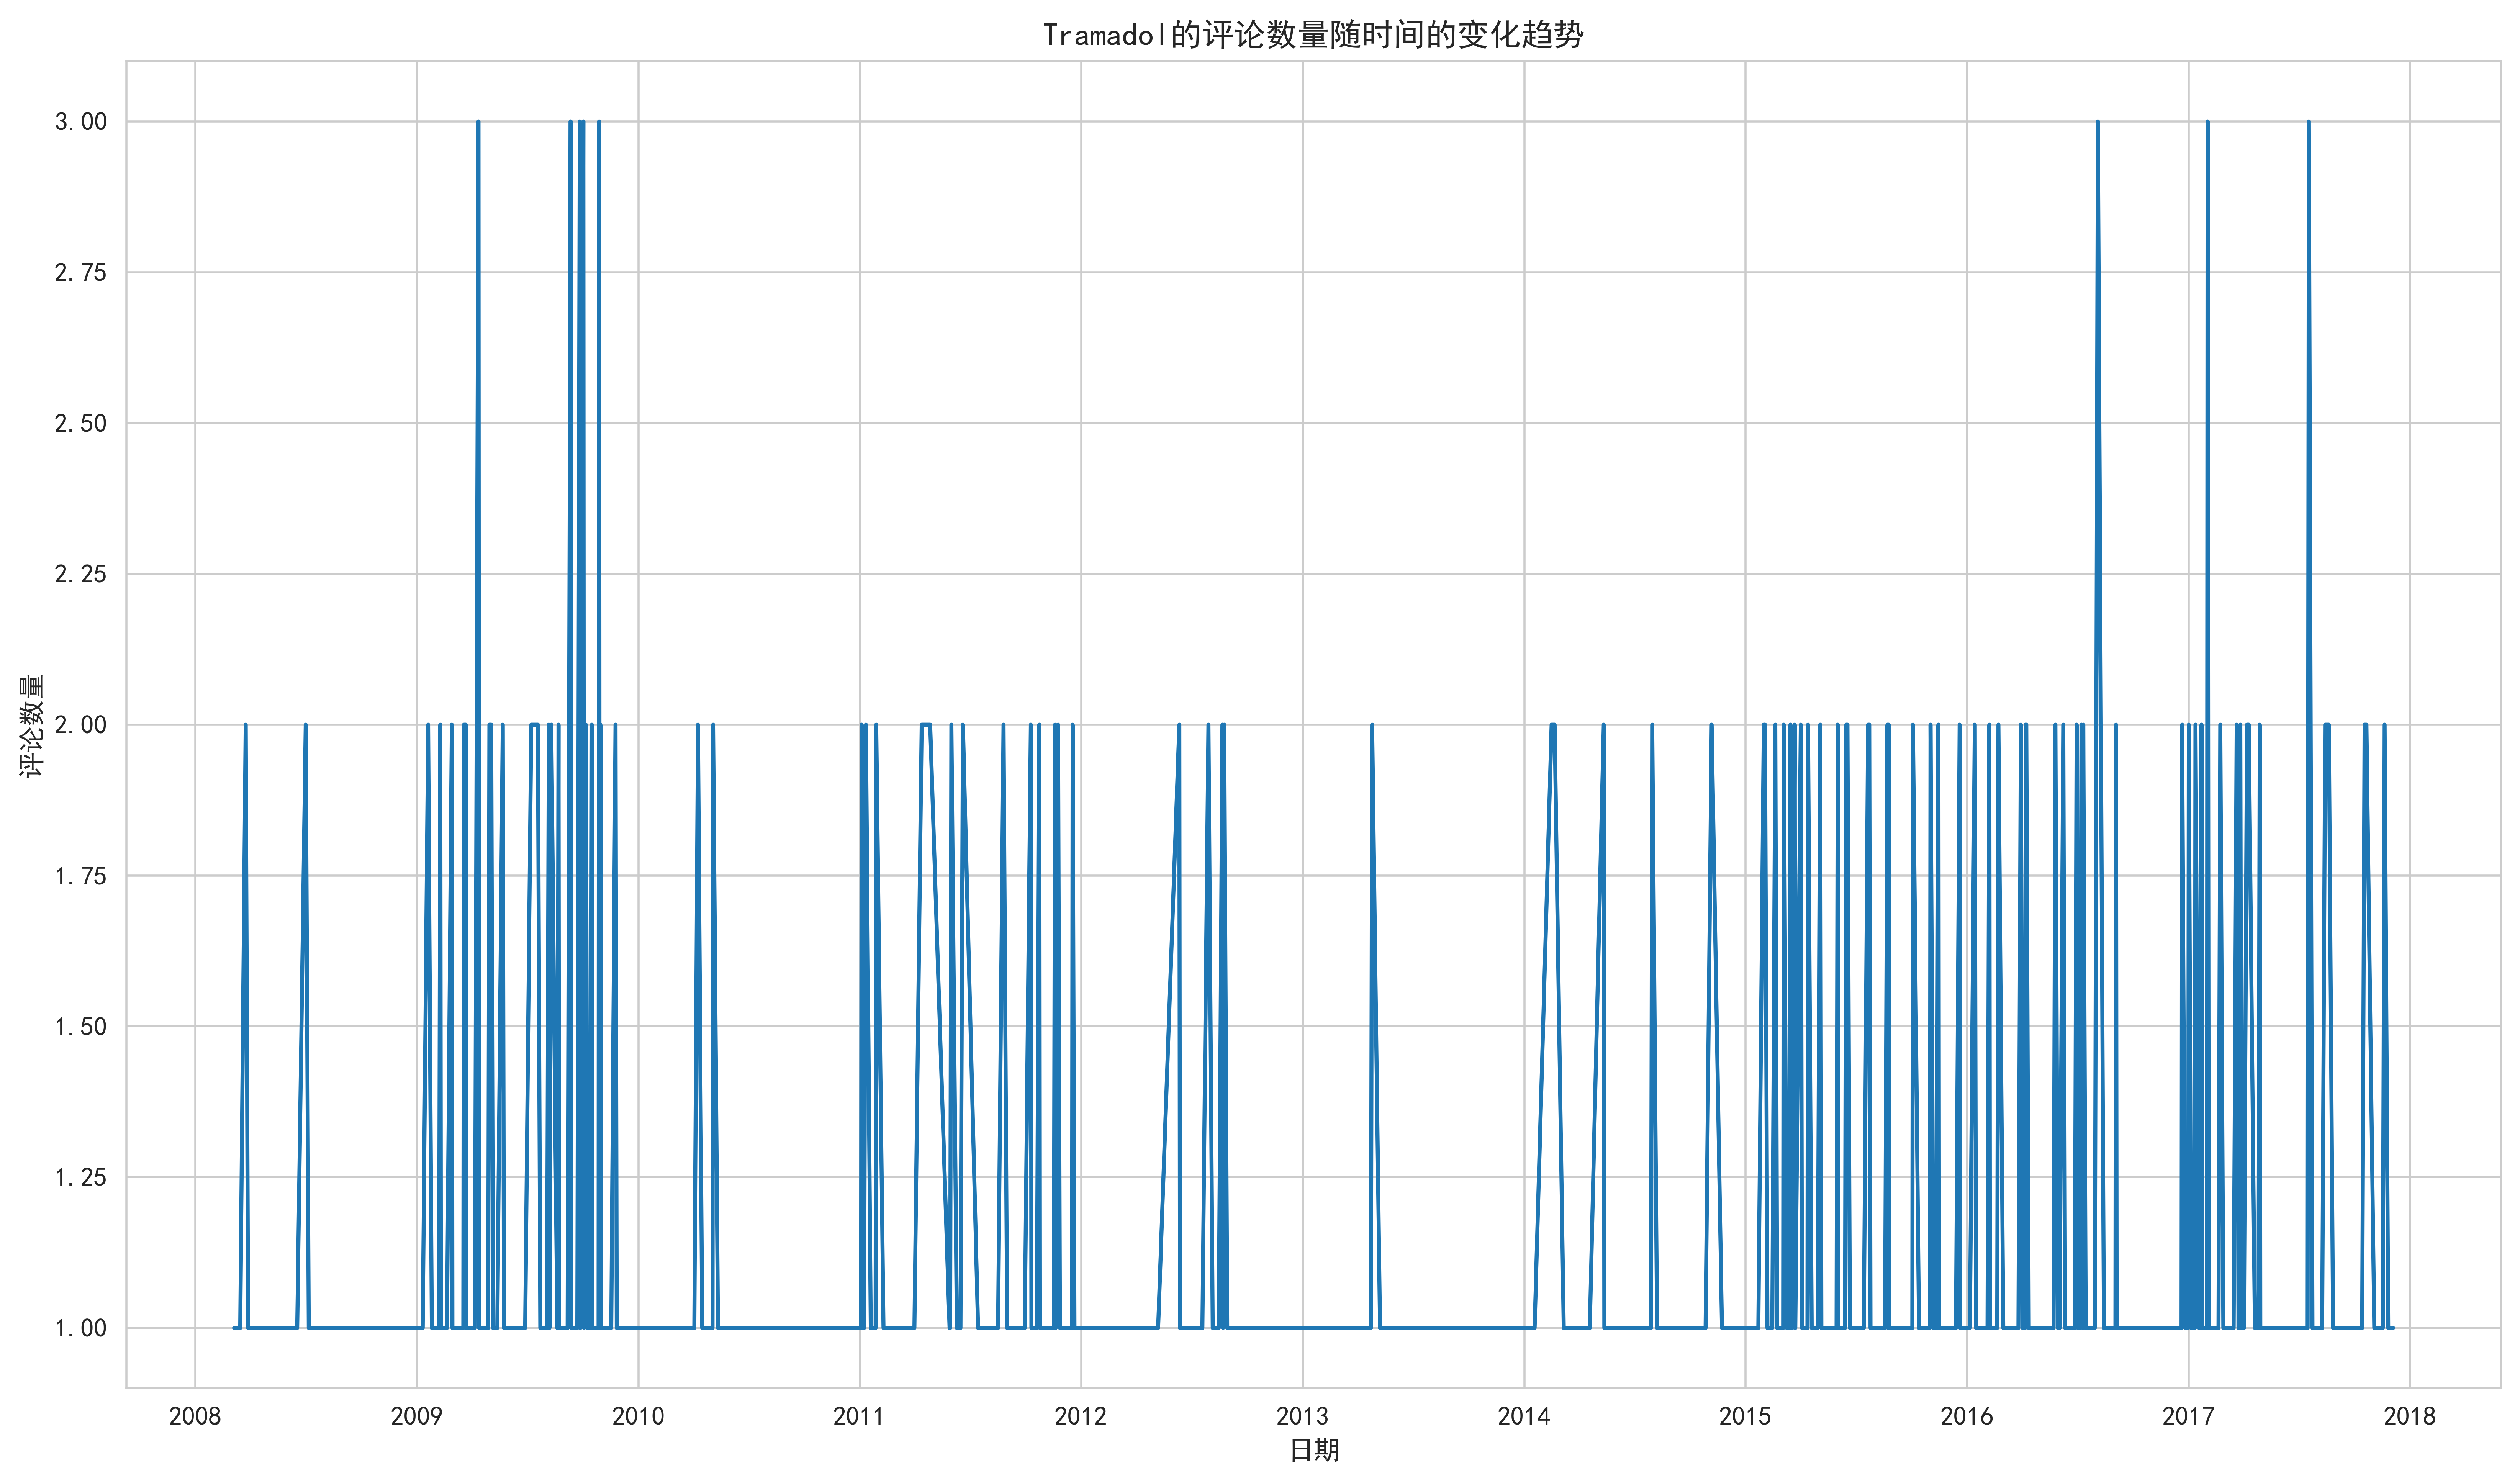

In [96]:
# 将日期列转换为日期类型
train_data['date'] = pd.to_datetime(train_data['date'])

# 计算每个日期的平均评级
rating_trend = train_data.groupby('date')['rating'].mean()

# 绘制评级随时间的变化趋势
plt.figure(figsize=(16, 12))
plt.plot(rating_trend)
plt.title('药物评级随时间的变化趋势')
plt.xlabel('日期')
plt.ylabel('平均评级')
plt.show()

# 选择一种药物，例如Tramadol
drug = 'Tramadol'

# 计算该药物每个日期的评论数量
review_count_trend = train_data[train_data['drugName'] == drug].groupby('date').size()

# 绘制评论数量随时间的变化趋势
plt.figure(figsize=(16, 9))
plt.plot(review_count_trend)
plt.title(f'{drug}的评论数量随时间的变化趋势')
plt.xlabel('日期')
plt.ylabel('评论数量')
plt.show()

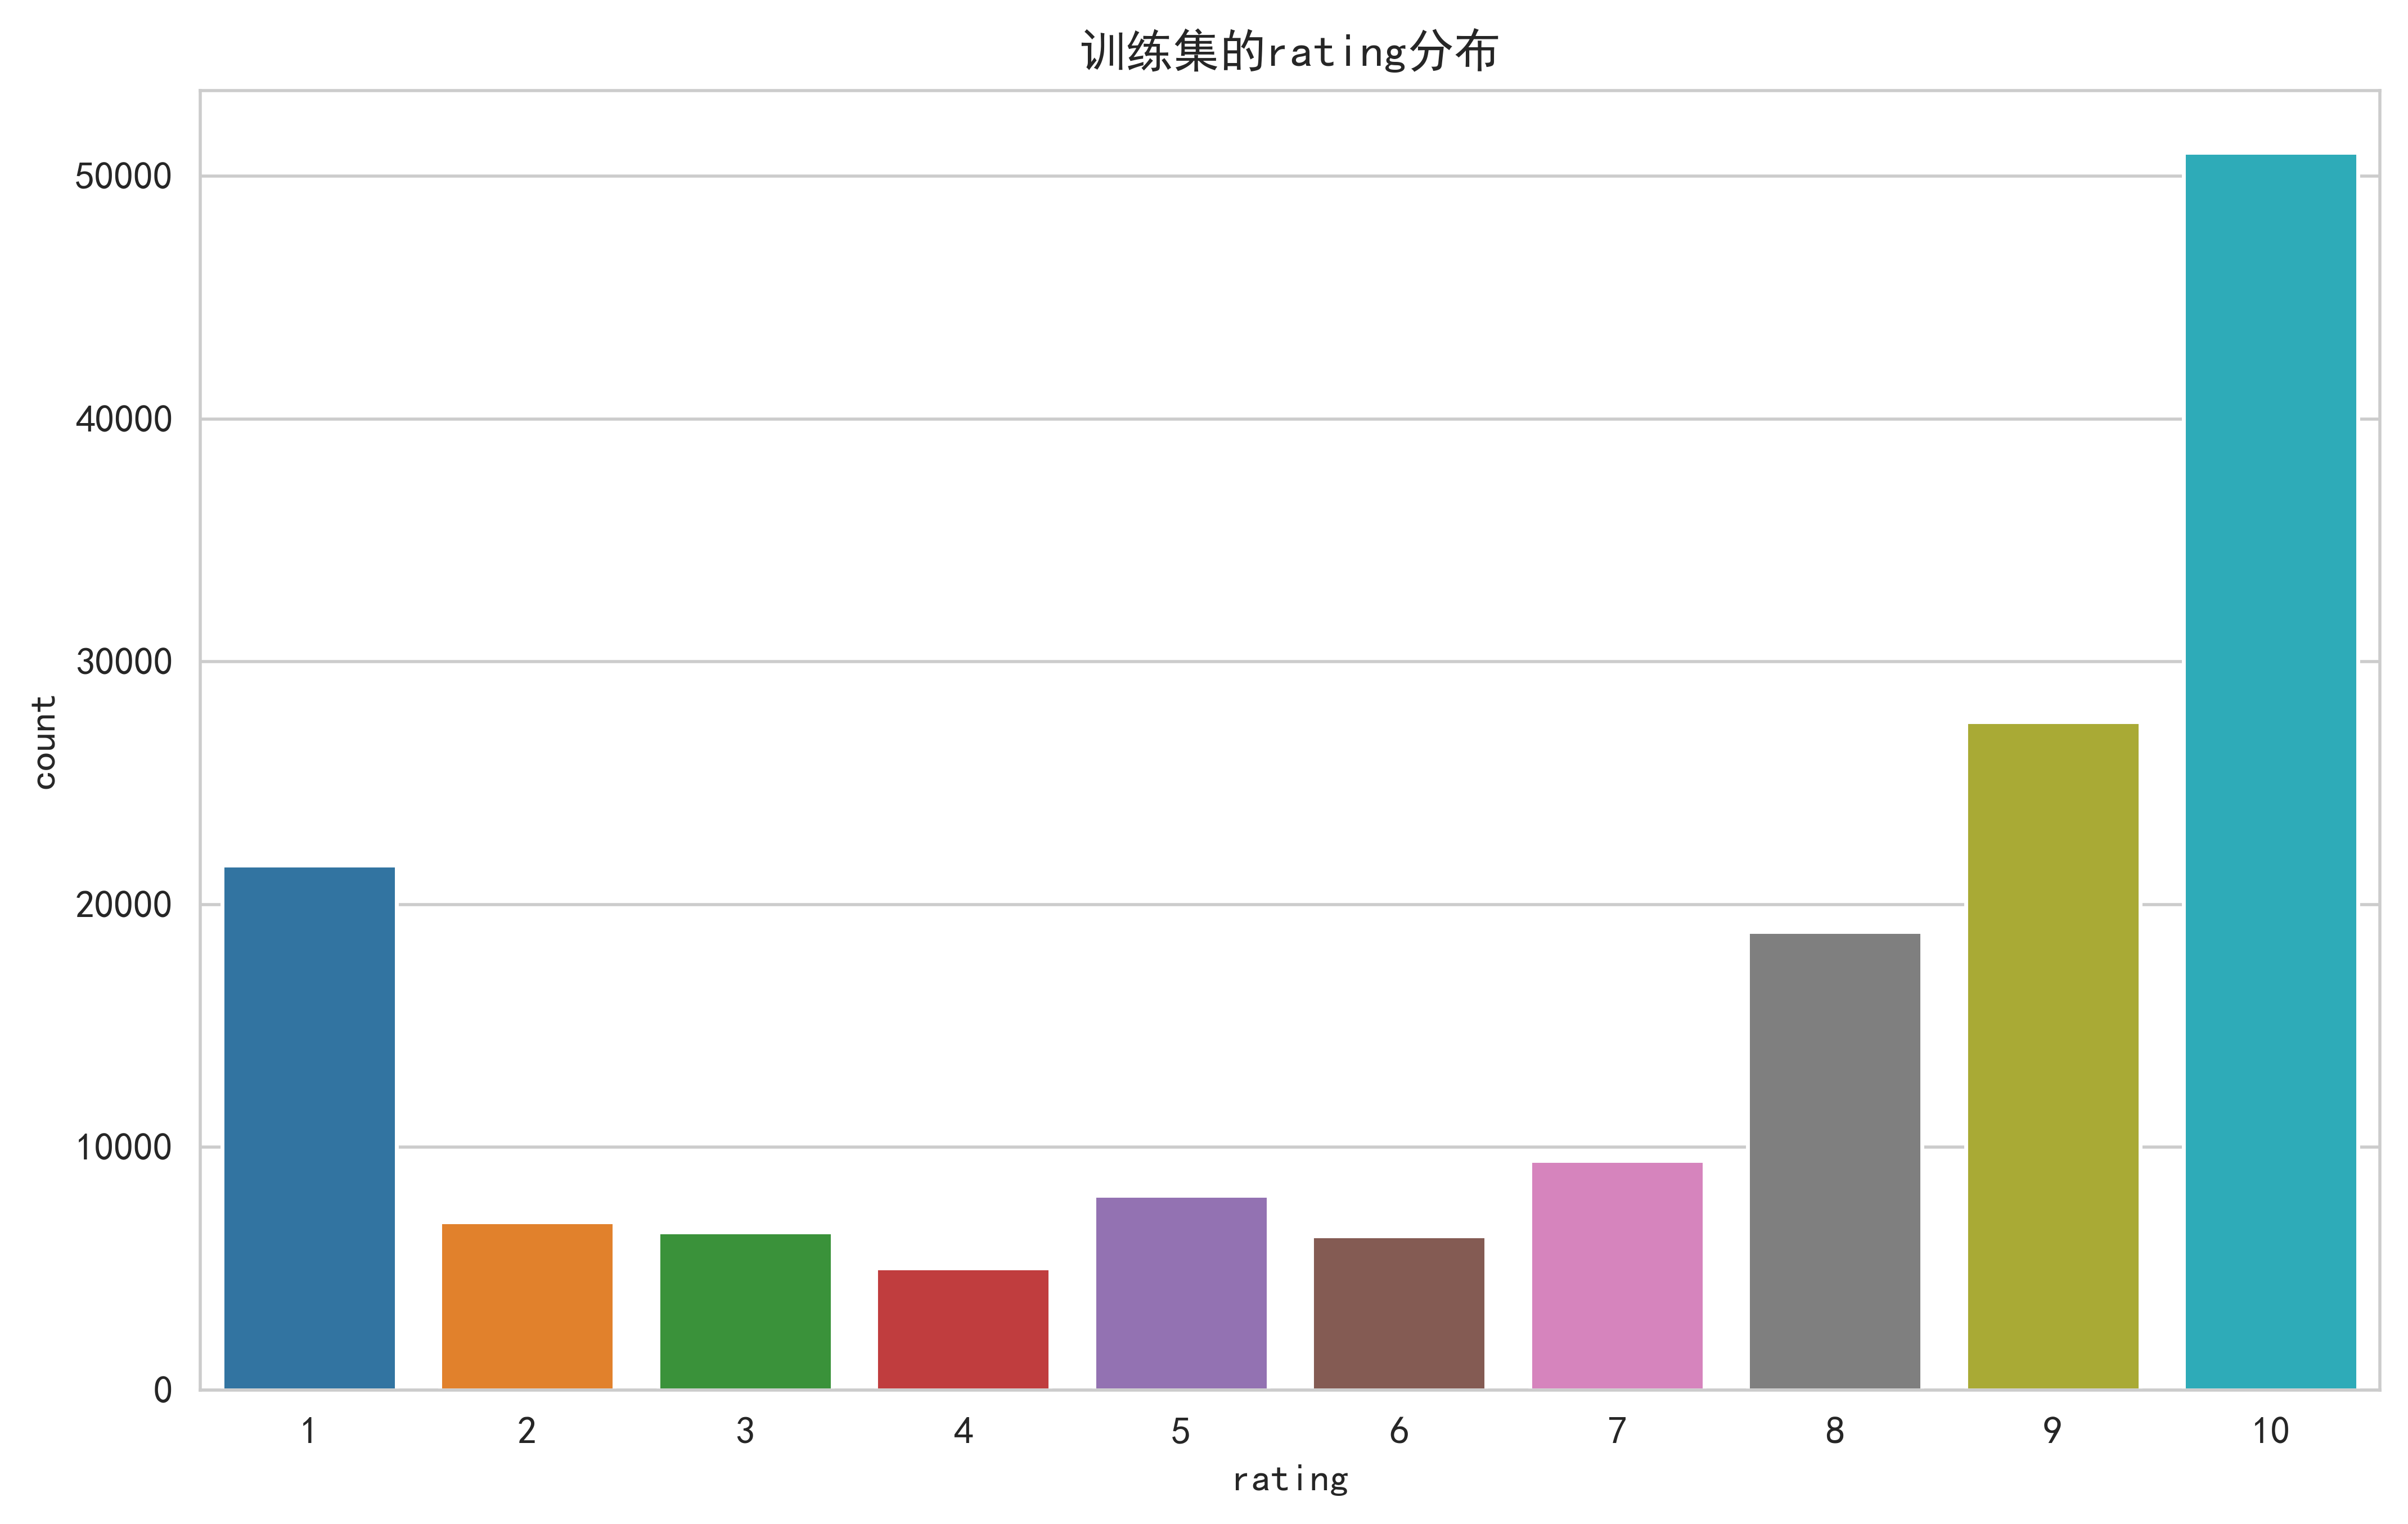

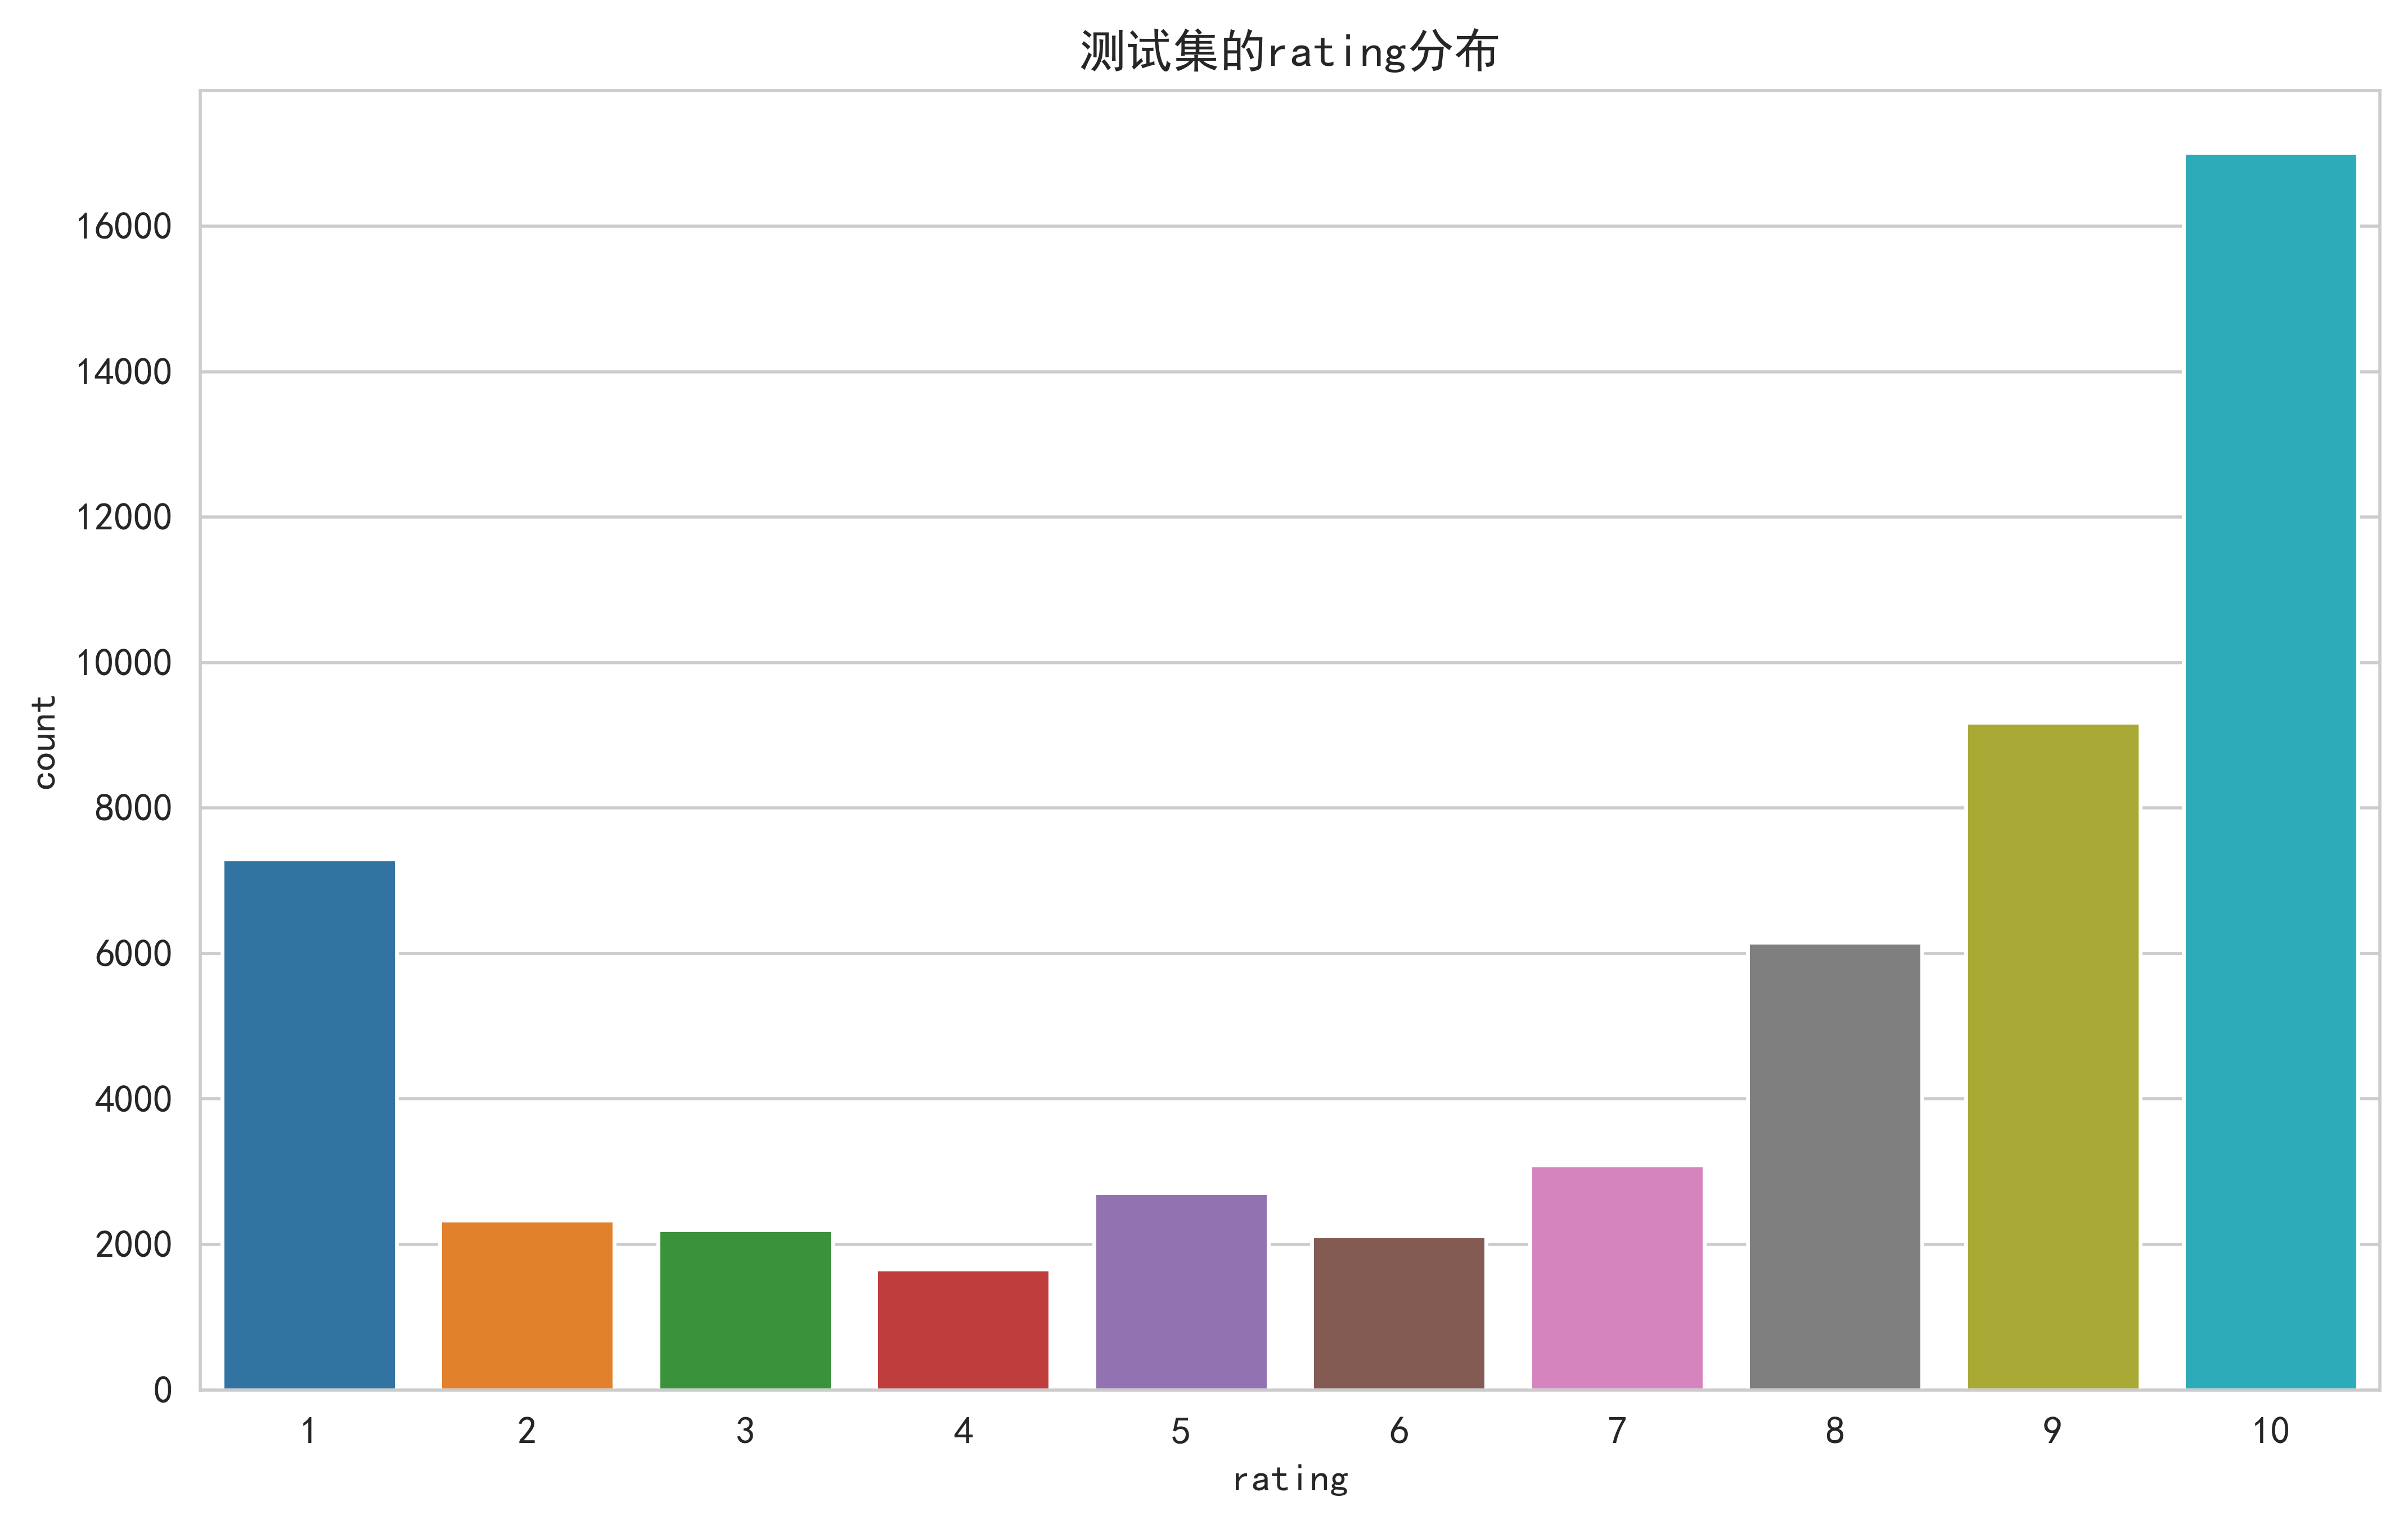

In [97]:

# 设置绘图风格
# sns.set(style='whitegrid')

# 绘制训练集的rating分布

sns.countplot(x='rating', data=train_data)
plt.title('训练集的rating分布')
plt.show()

# 绘制测试集的rating分布

sns.countplot(x='rating', data=test_data)
plt.title('测试集的rating分布')
plt.show()

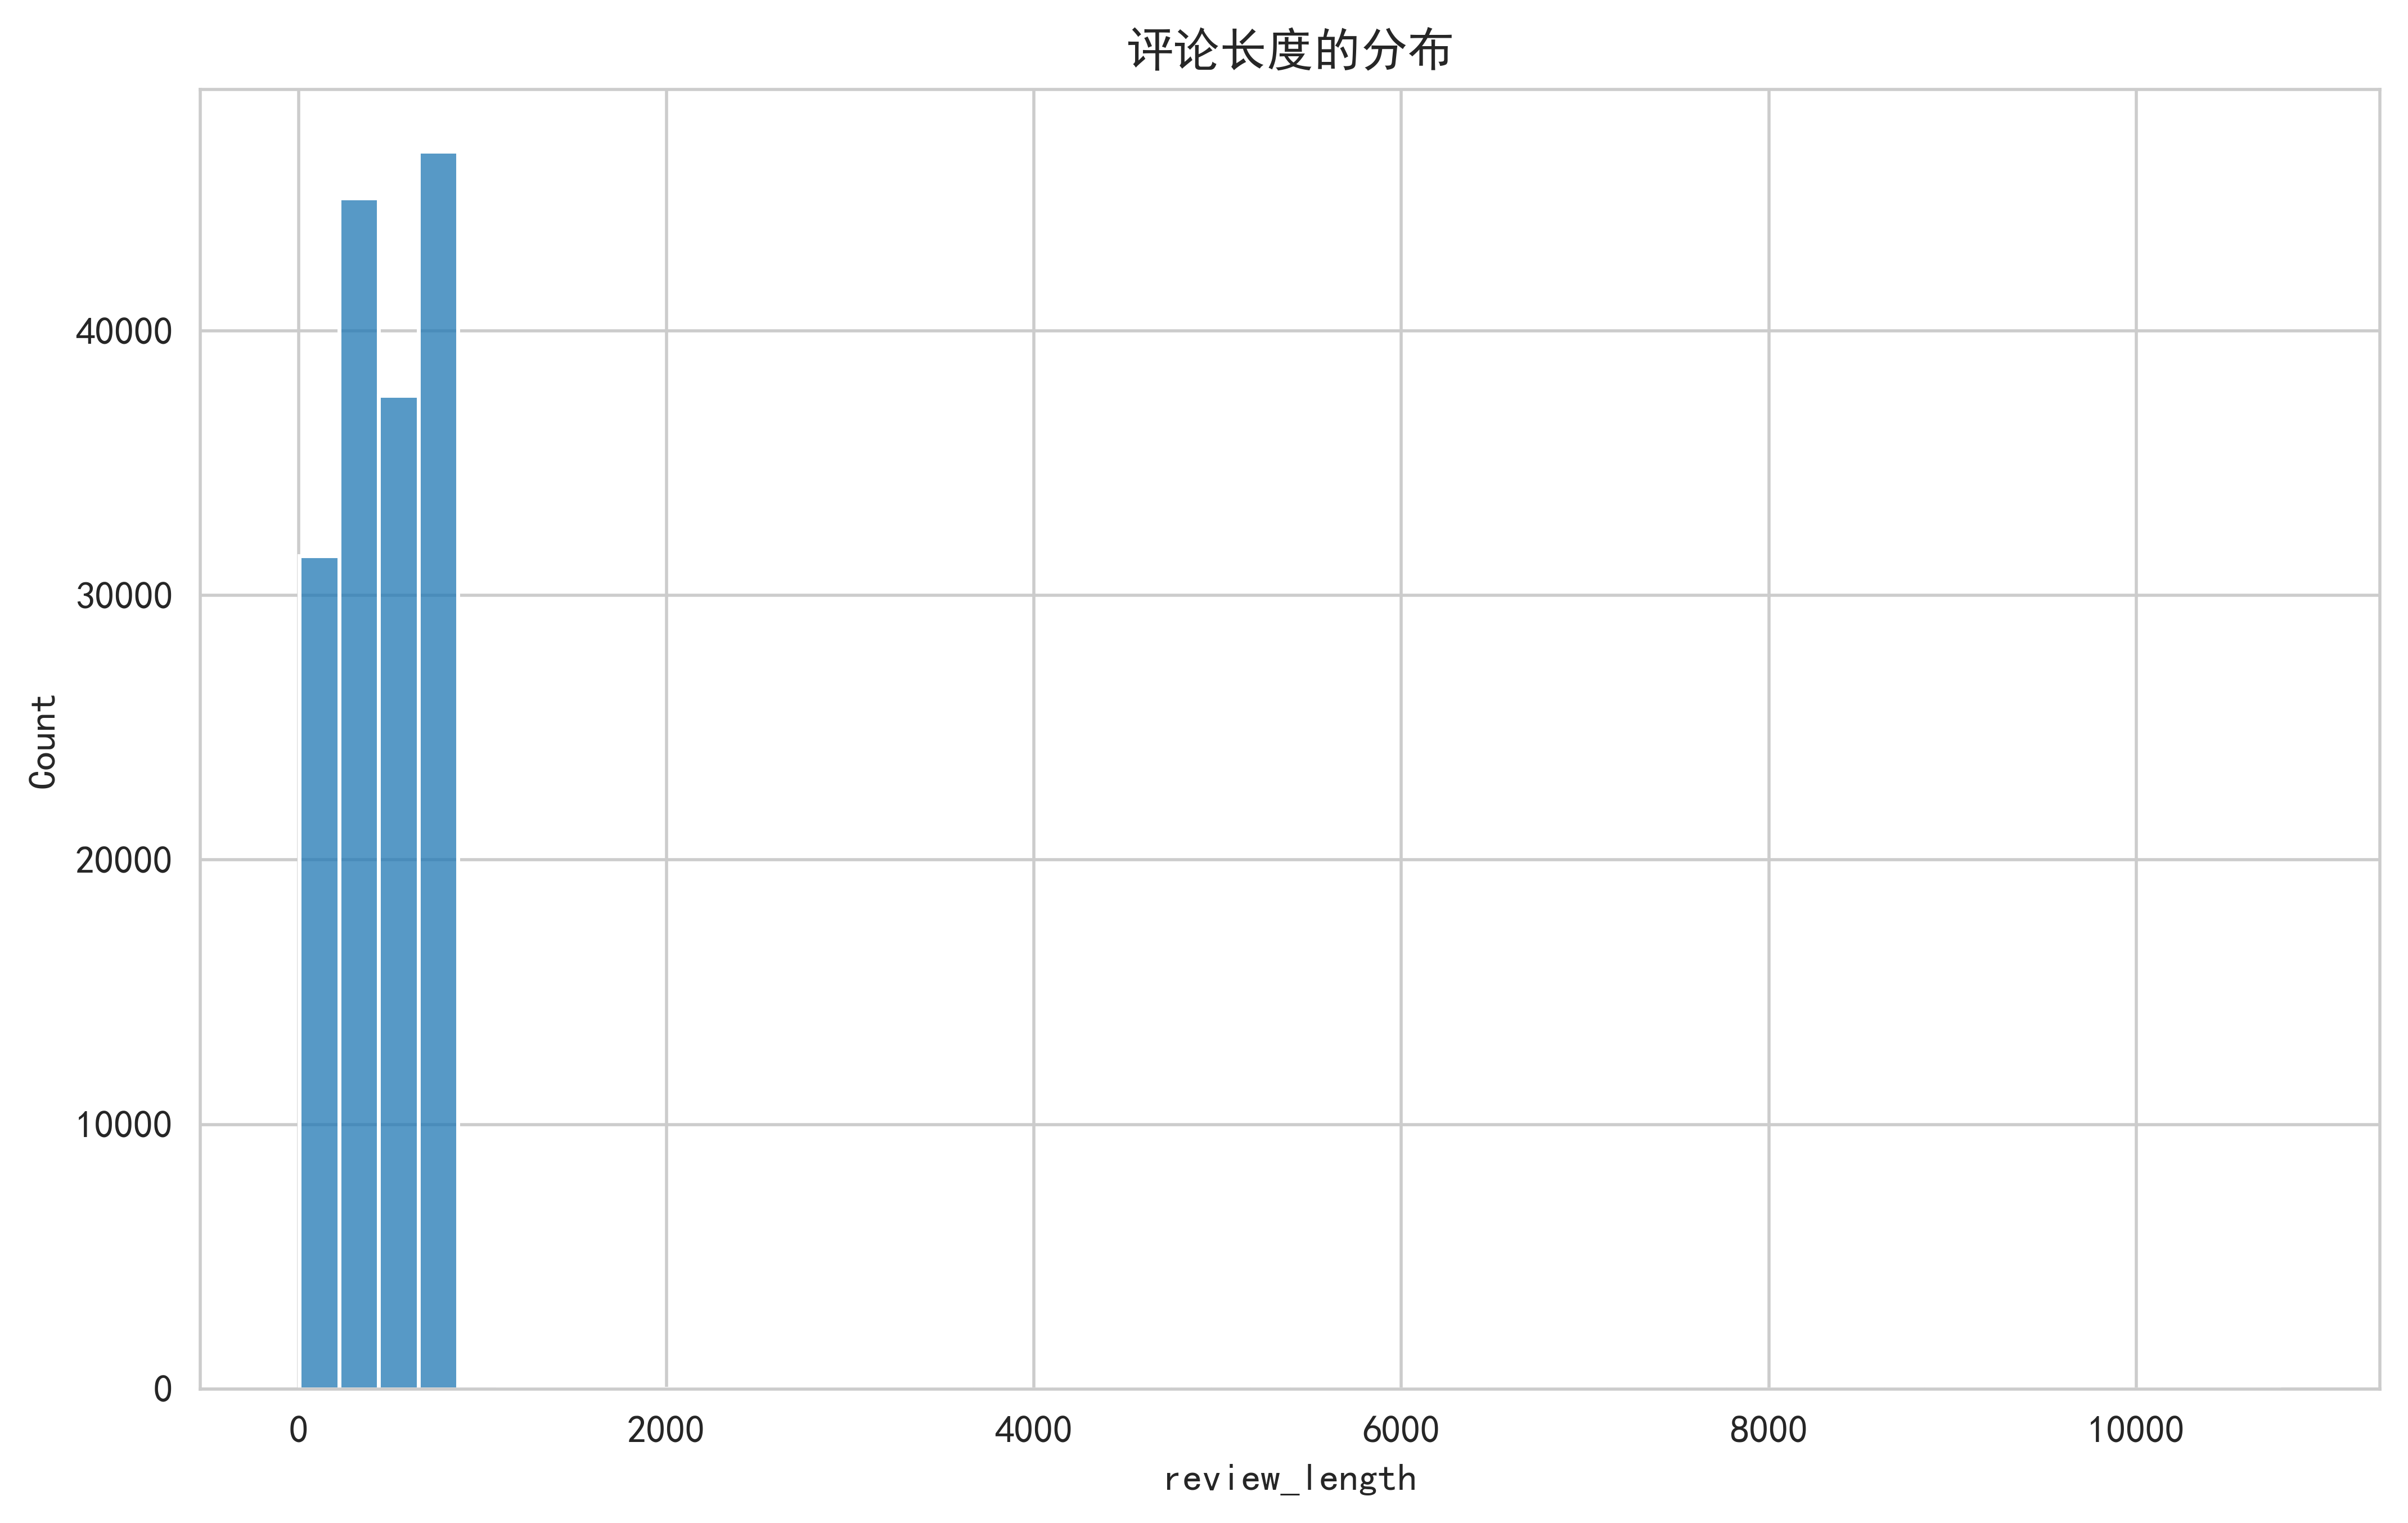

In [98]:
# 创建一个新的特征，表示每个评论的字符数
train_data['review_length'] = train_data['review'].apply(len)

# 绘制评论长度的分布

sns.histplot(train_data['review_length'], bins=50)
plt.title('评论长度的分布')
plt.show()

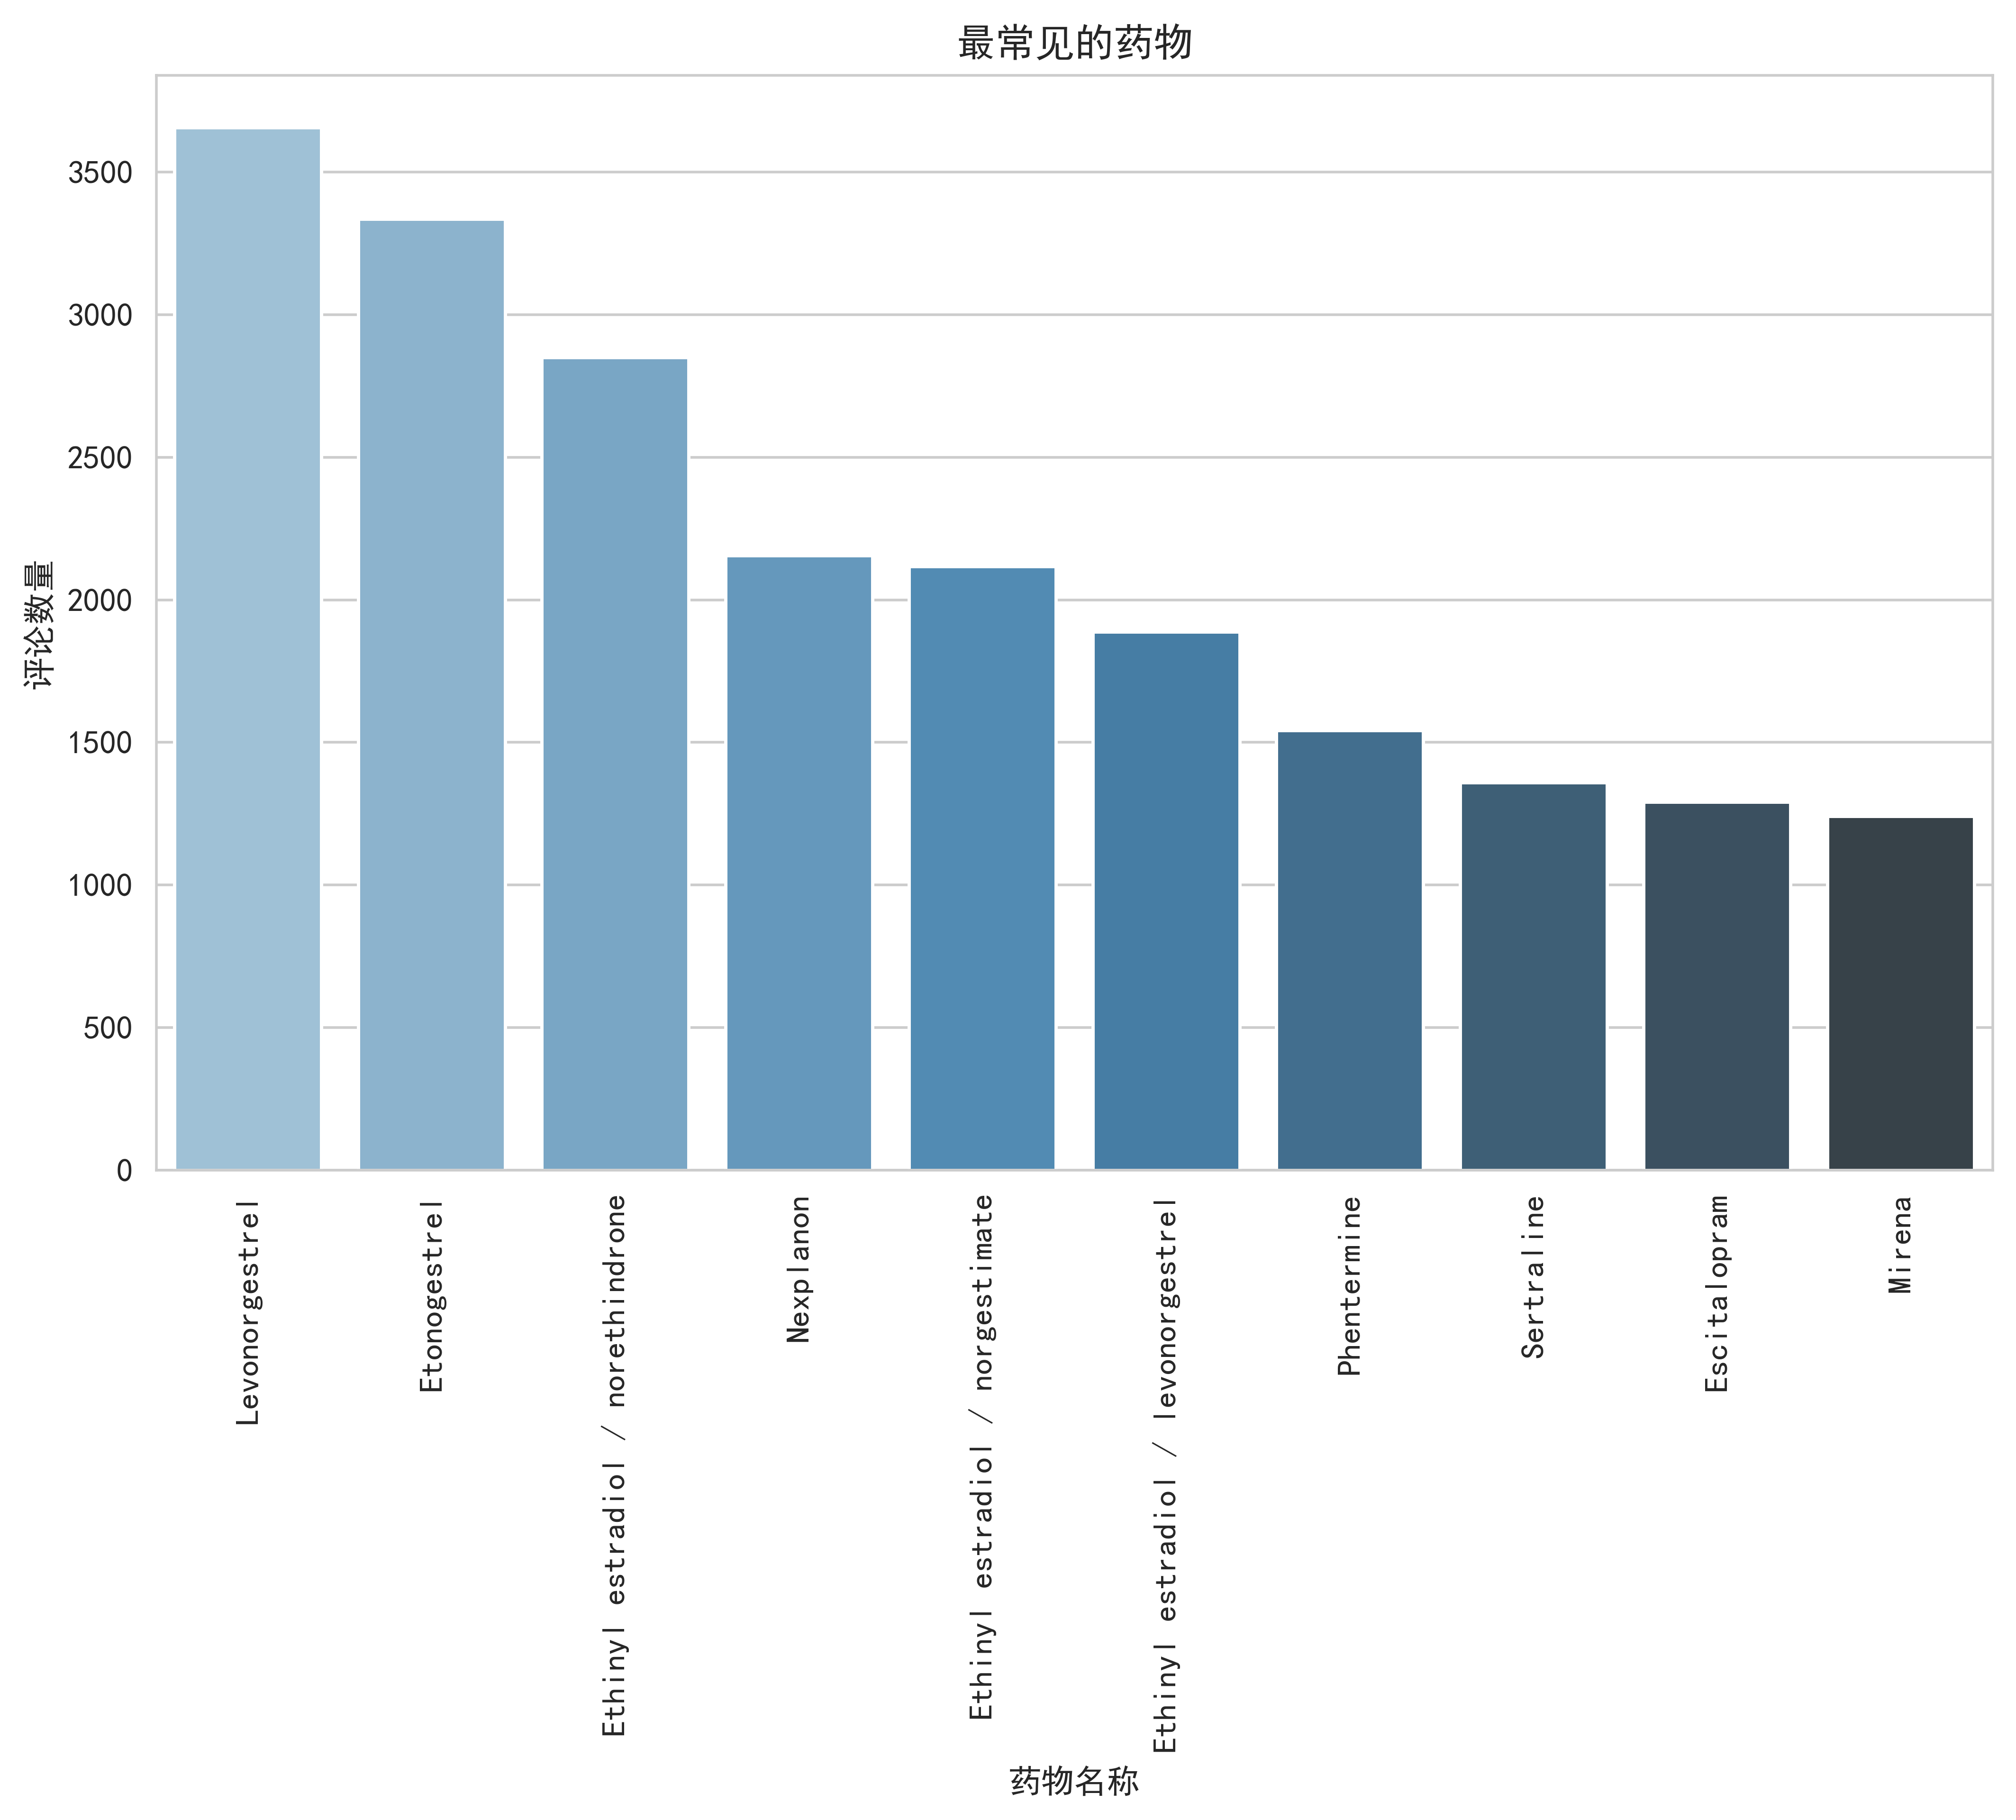

In [99]:
# 计算每种药物的评论数量
drug_counts = train_data['drugName'].value_counts().head(10)

# 绘制最常见的药物

sns.barplot(x=drug_counts.index, y=drug_counts.values, palette='Blues_d')
plt.title('最常见的药物')
plt.xlabel('药物名称')
plt.ylabel('评论数量')
plt.xticks(rotation=90)
plt.show()

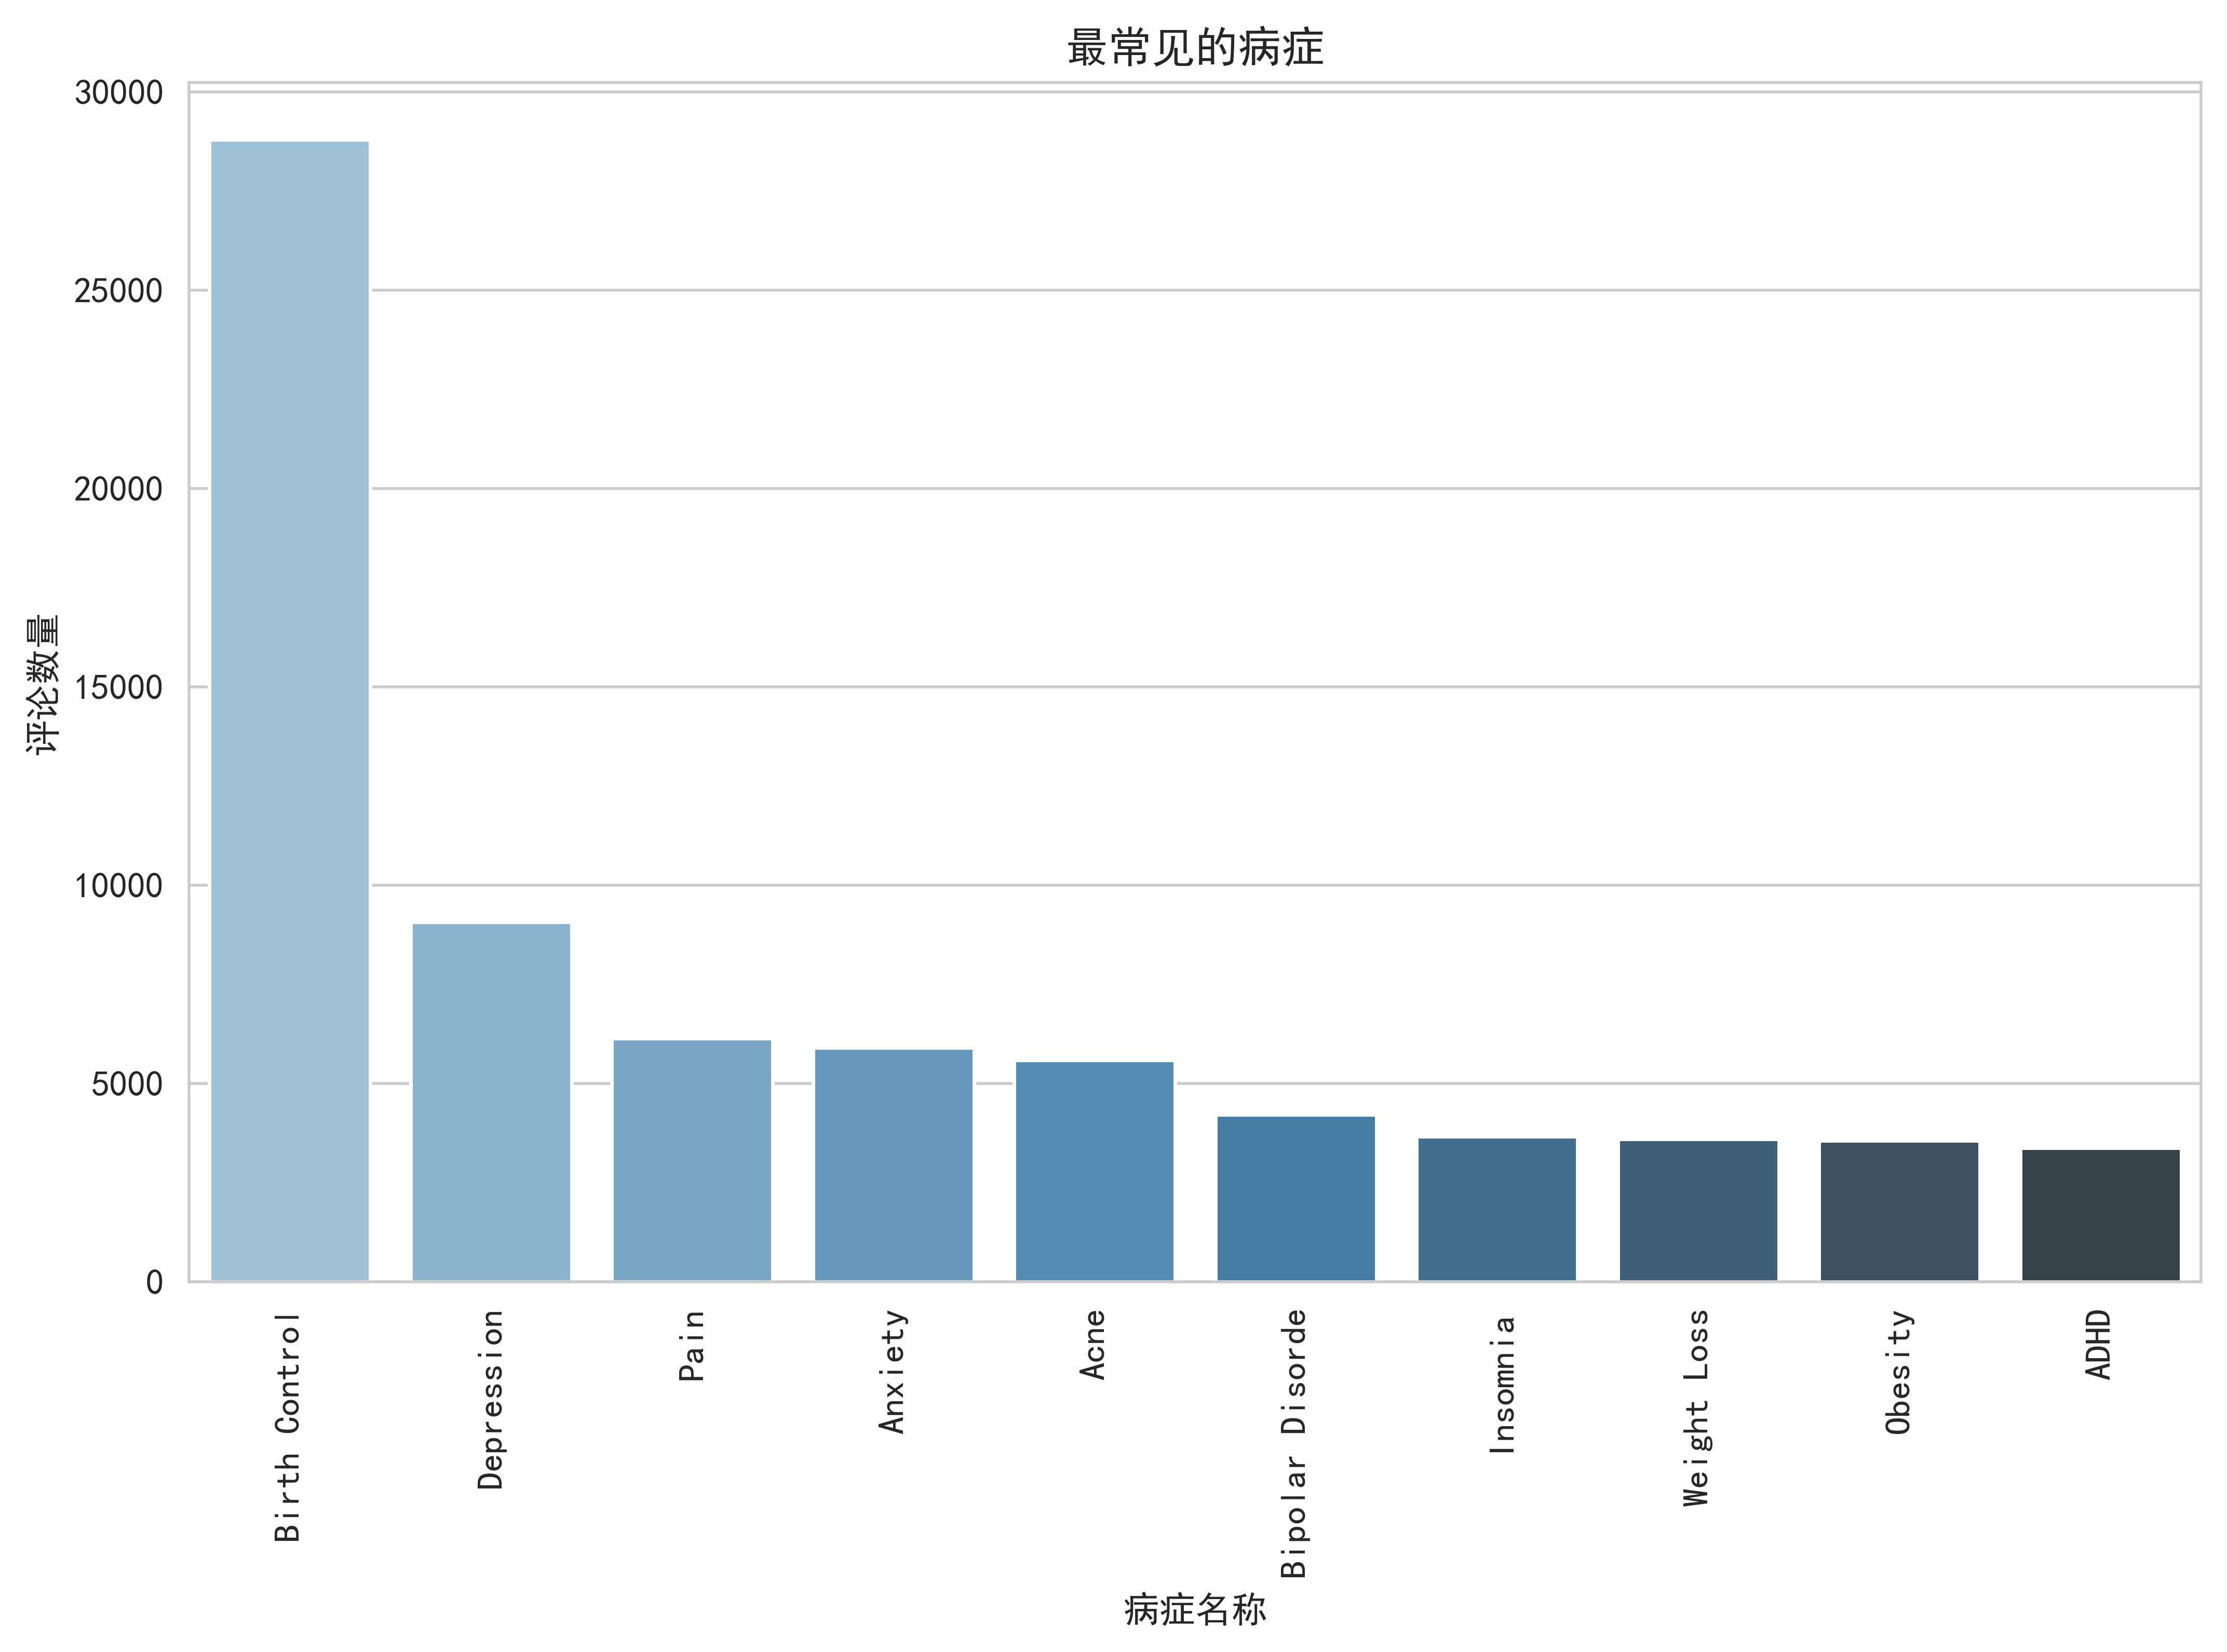

In [100]:
# 计算每种病症的评论数量
condition_counts = train_data['condition'].value_counts().head(10)

# 绘制最常见的病症

sns.barplot(x=condition_counts.index, y=condition_counts.values, palette='Blues_d')
plt.title('最常见的病症')
plt.xlabel('病症名称')
plt.ylabel('评论数量')
plt.xticks(rotation=90)
plt.show()

In [101]:
# 将训练集和测试集中的缺失值替换为'Unknown'
train_data['condition'].fillna('Unknown', inplace=True)
test_data['condition'].fillna('Unknown', inplace=True)

# 再次检查训练集和测试集的缺失值情况
print('训练集缺失值情况:')
print(train_data.isnull().sum())
print('\n测试集缺失值情况:')
print(test_data.isnull().sum())

训练集缺失值情况:
uniqueID         0
drugName         0
condition        0
review           0
rating           0
date             0
usefulCount      0
review_length    0
dtype: int64

测试集缺失值情况:
uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64


In [102]:

# 将评级转换为二分类标签
train_data['label'] = (train_data['rating'] > 5).astype(int)
test_data['label'] = (test_data['rating'] > 5).astype(int)

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(train_data['review'], train_data['label'], test_size=0.2, random_state=42)

# 创建TF-IDF向量化器和朴素贝叶斯分类器的管道
model = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())

# 训练模型
model.fit(X_train, y_train)
print('模型训练完成')

# 在验证集上评估模型
y_val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print('验证集准确率:', accuracy)

# 显示混淆矩阵
conf_mat = confusion_matrix(y_val, y_val_pred)
print('混淆矩阵:')
print(conf_mat)

模型训练完成
验证集准确率: 0.7580285182889027
混淆矩阵:
[[ 2037  7547]
 [  259 22417]]


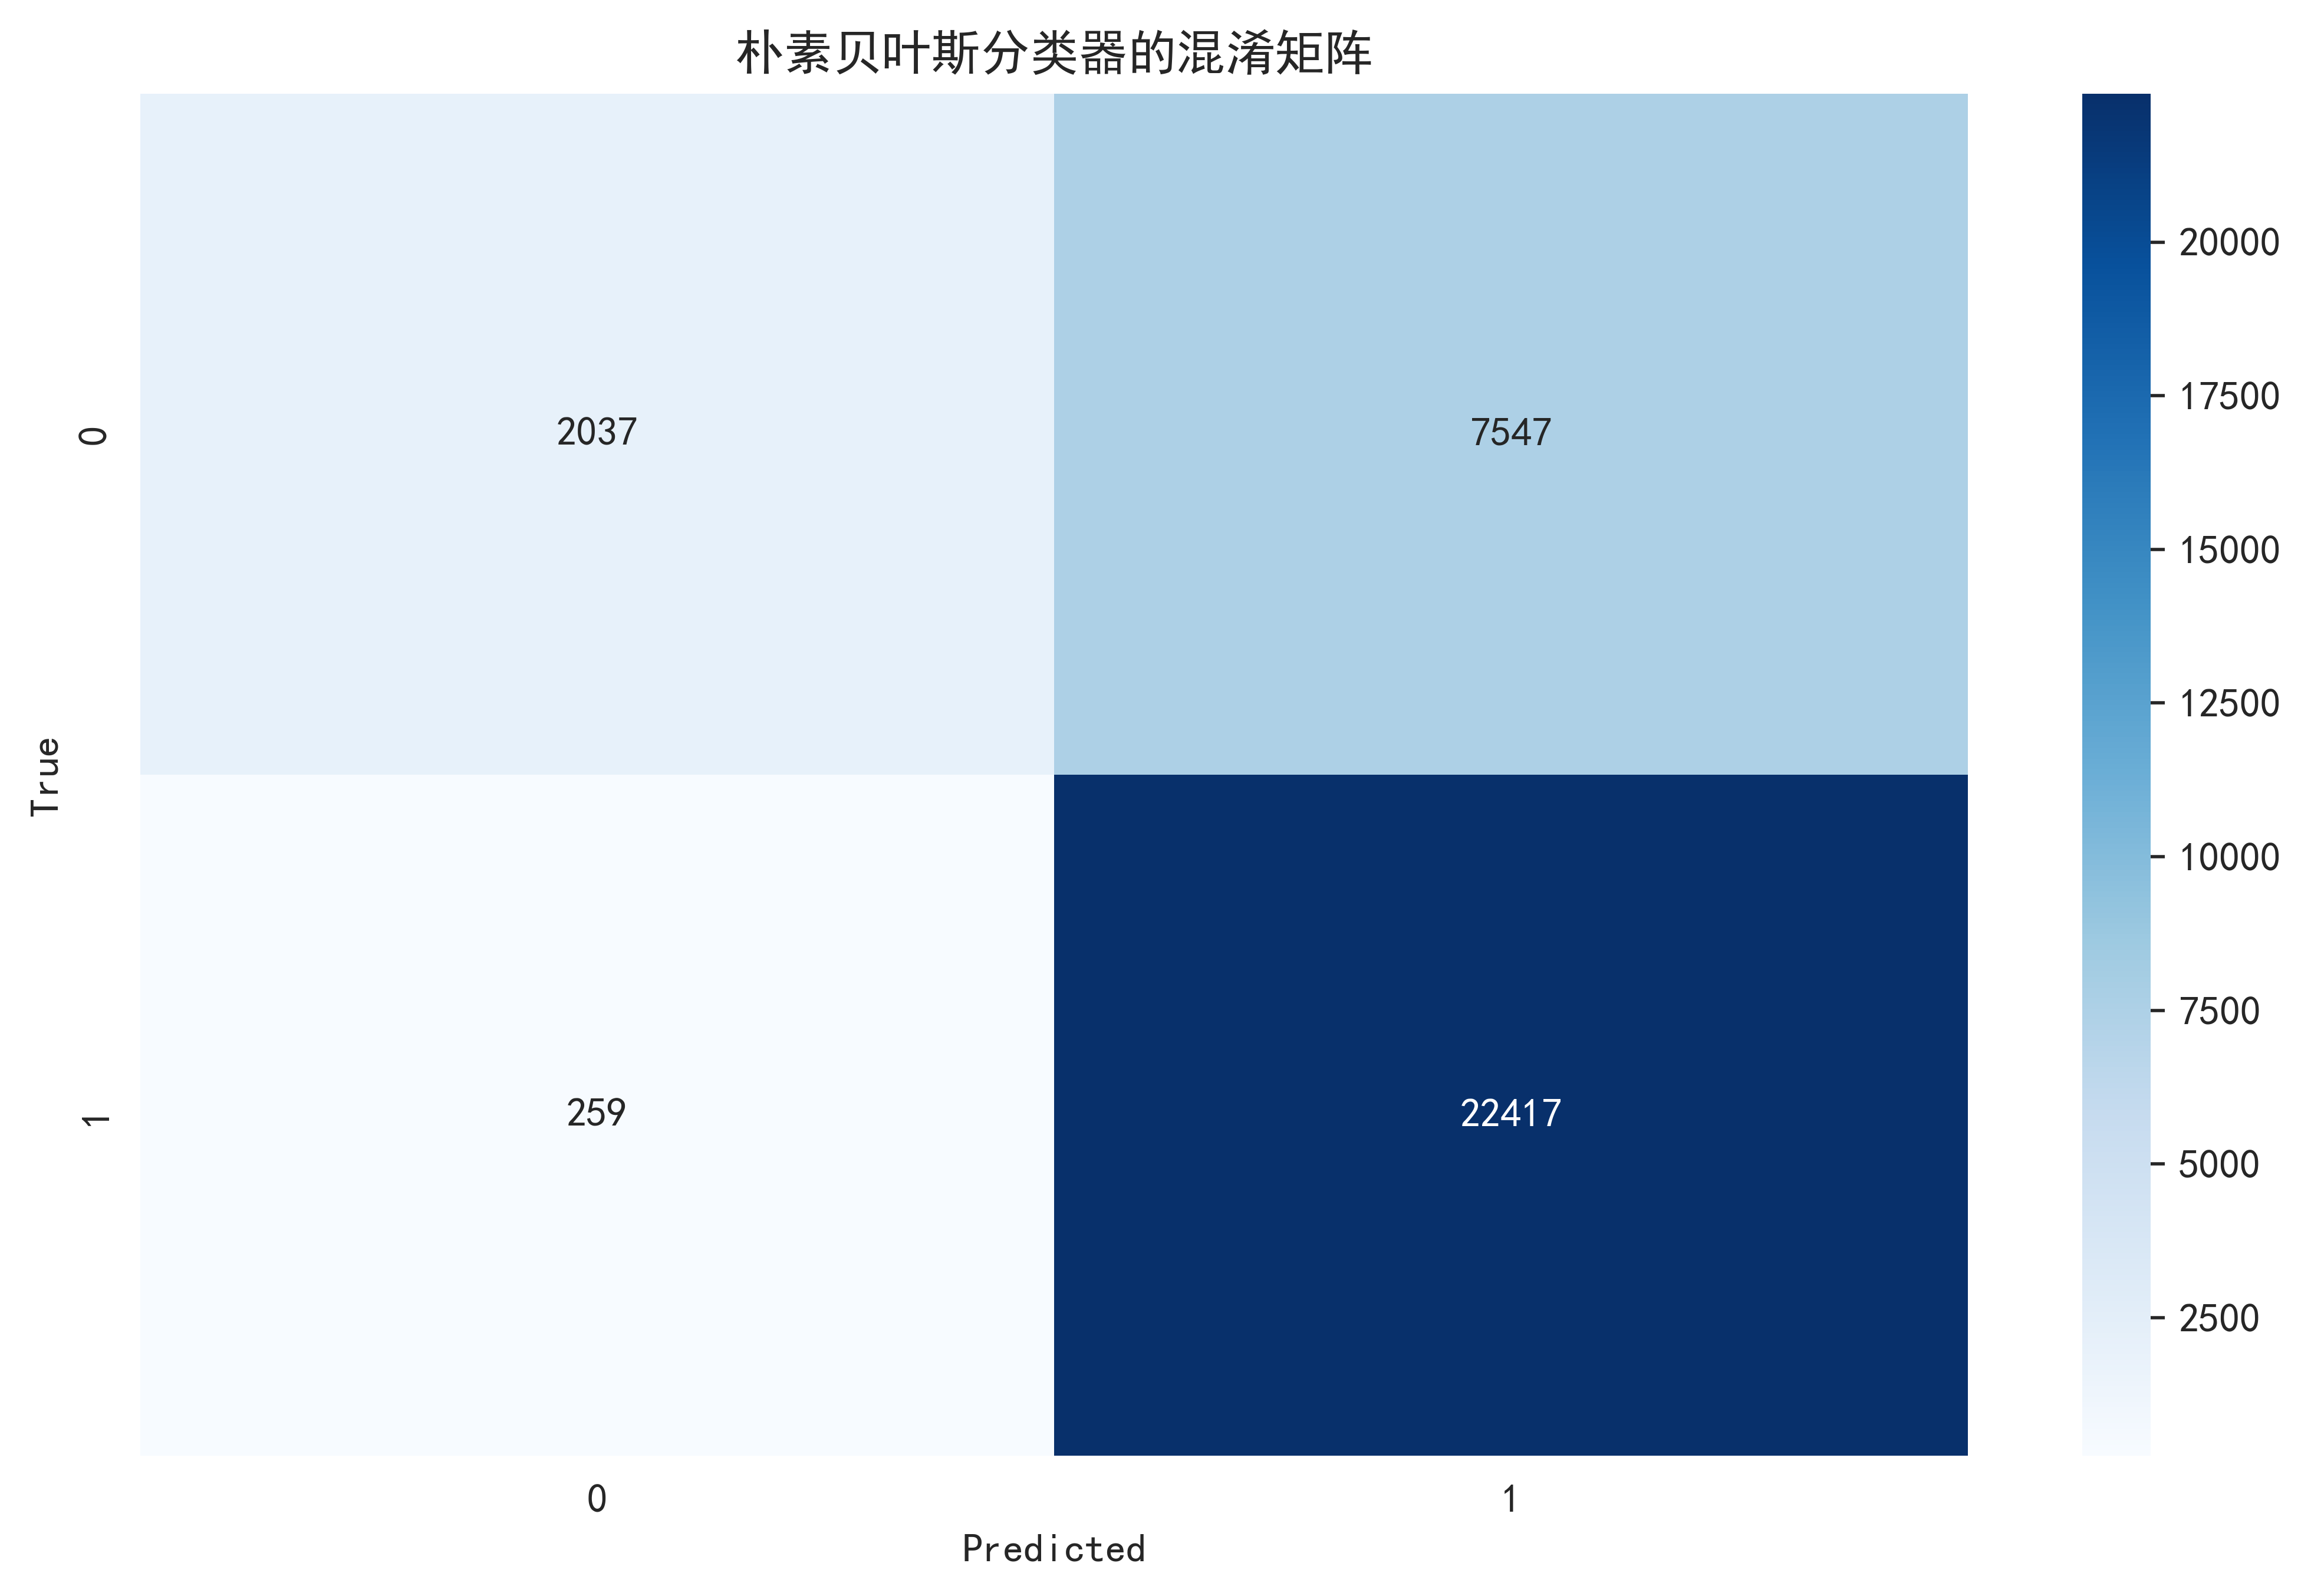

In [103]:
# 绘制混淆矩阵

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('朴素贝叶斯分类器的混淆矩阵')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [104]:
# 使用TF-IDF方法将评论转换为数值向量
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_data['review'])

# 将评级转换为情感标签：0-5为负面，6-10为正面
y = train_data['rating'].apply(lambda x: 'negative' if x <= 5 else 'positive')

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练一个支持向量机分类器
clf = LinearSVC()
clf.fit(X_train, y_train)

# 使用分类器预测验证集的情感极性
y_pred = clf.predict(X_val)

# 计算准确率
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

0.8569125852448853


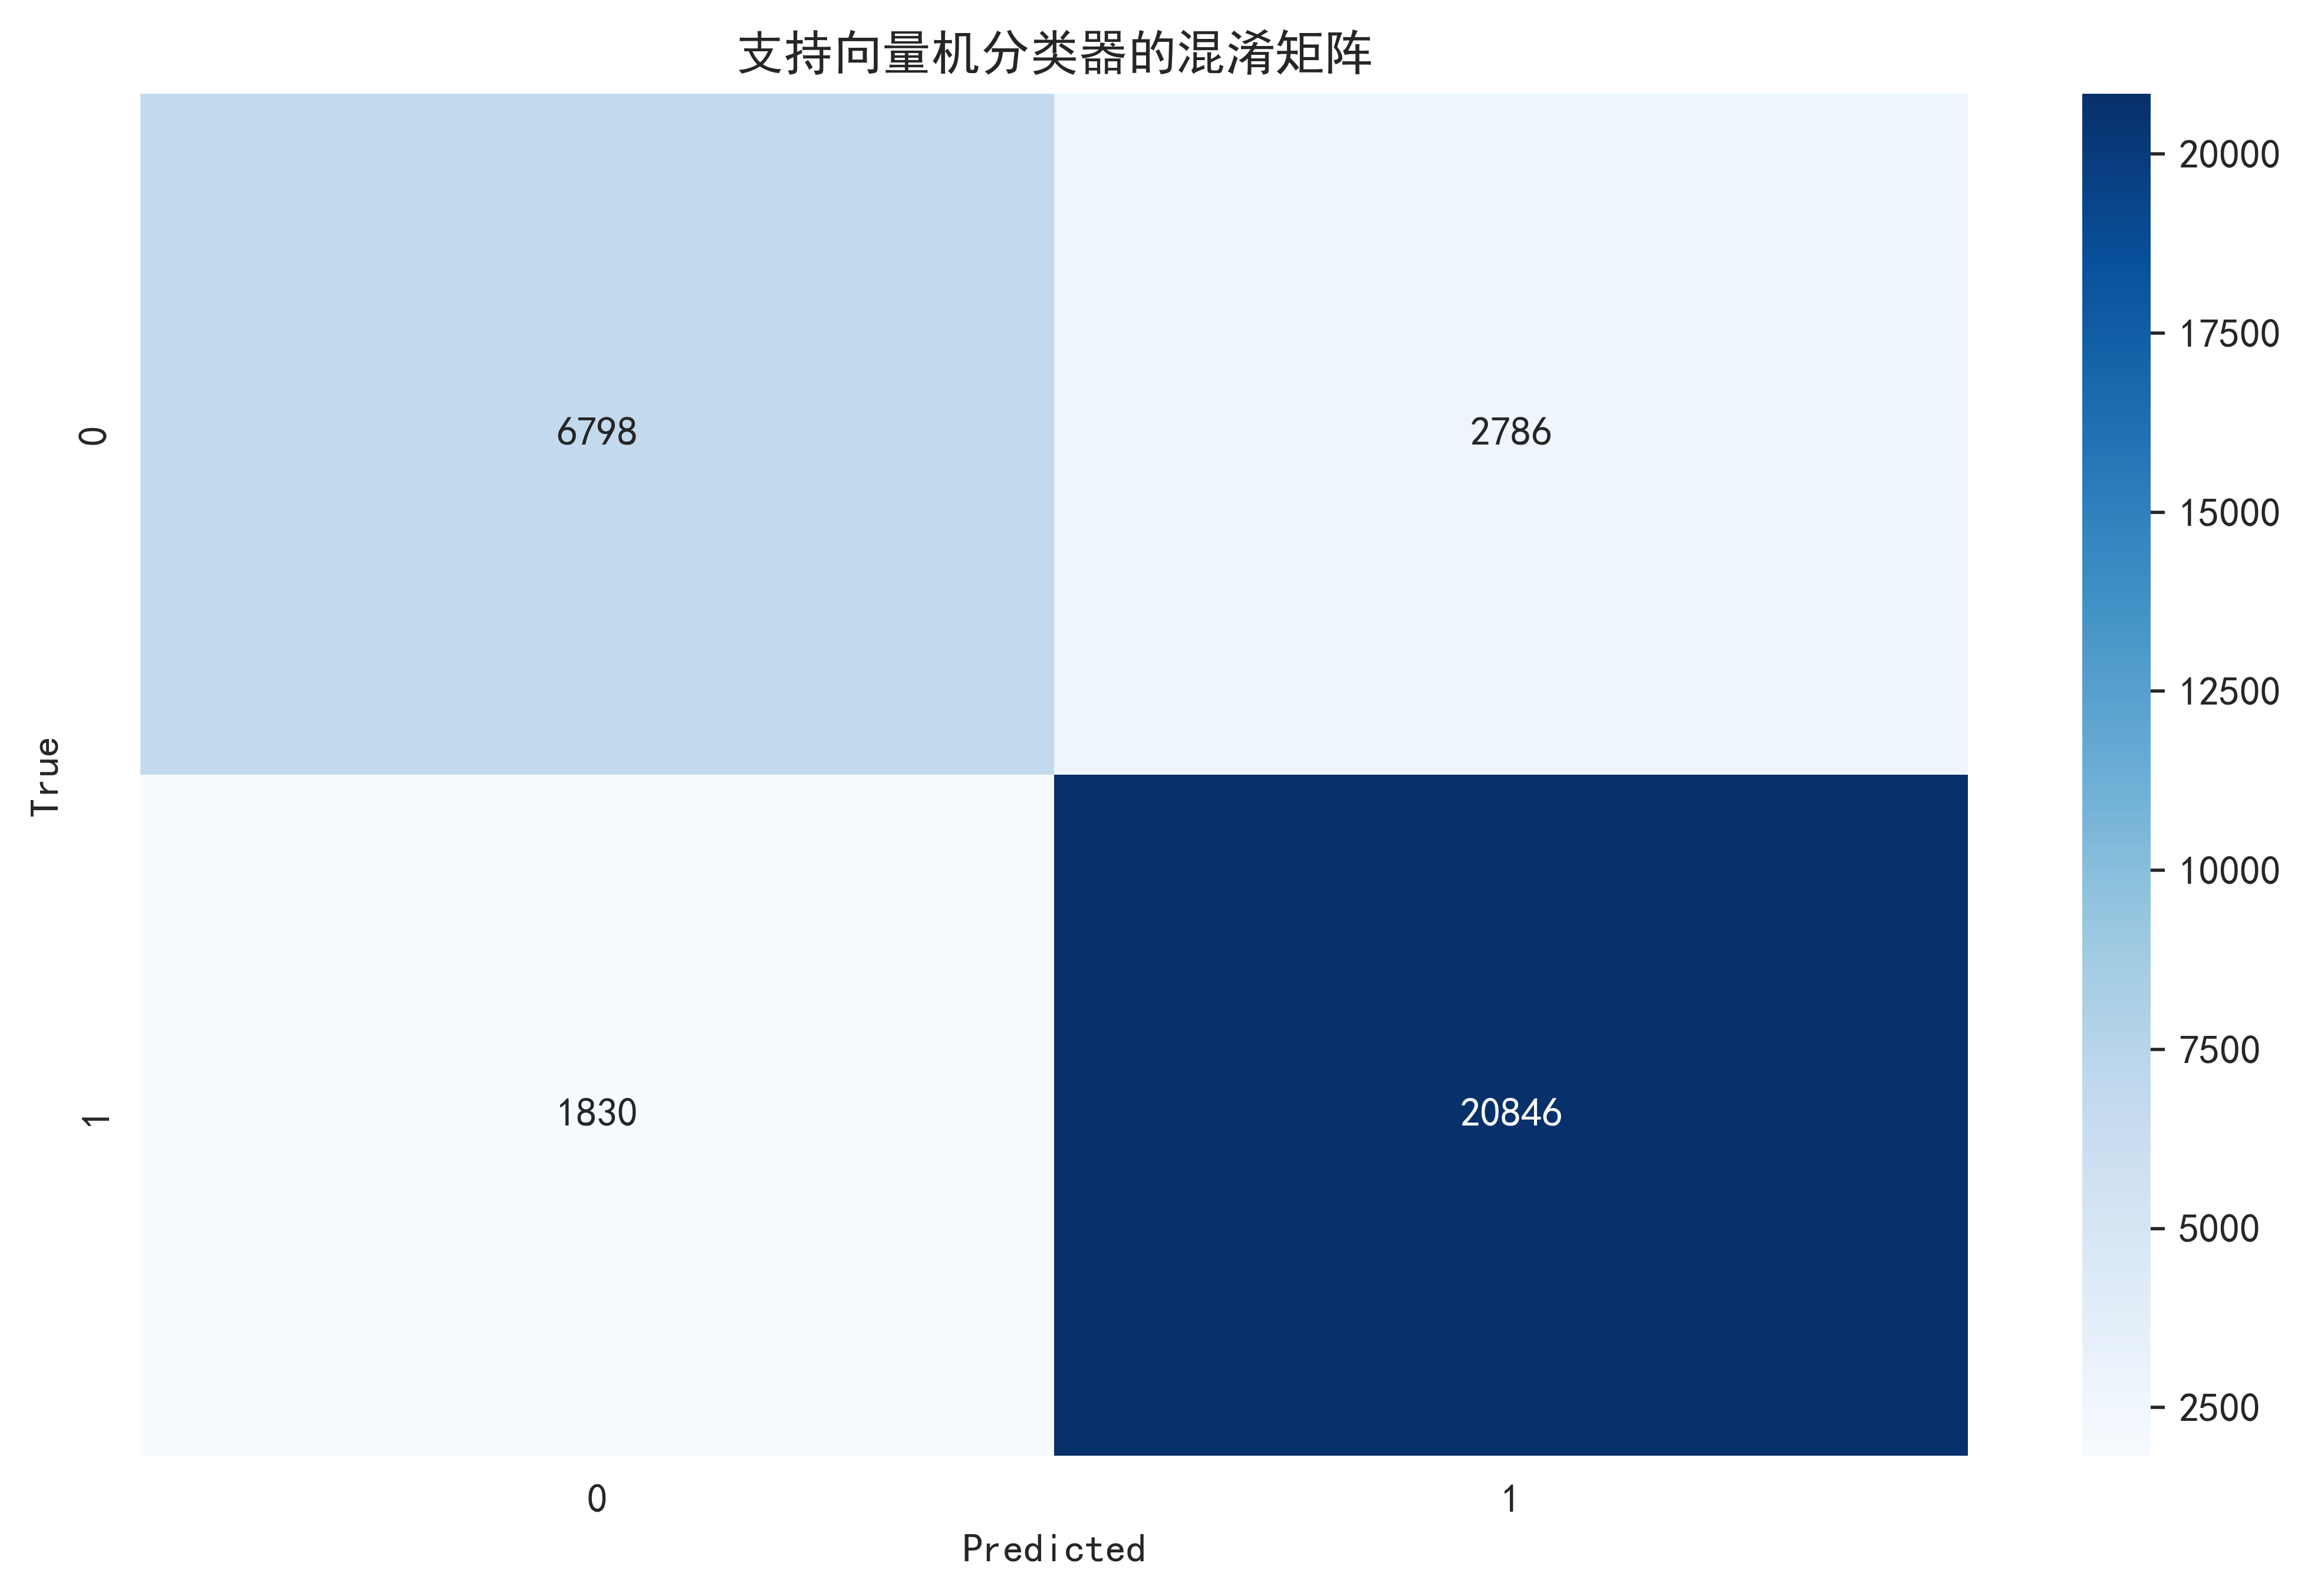

In [105]:
# 生成混淆矩阵
cm = confusion_matrix(y_val, y_pred)

# 绘制混淆矩阵

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('支持向量机分类器的混淆矩阵')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [106]:


# 选择评级最高的1000种药物
top_drugs = train_data[train_data['rating'] == 10]['drugName'].value_counts().head(1000).index
subset_data = train_data[train_data['drugName'].isin(top_drugs)]

# 创建药物和病症的交叉表
cross_tab = pd.crosstab(index=subset_data['drugName'], columns=subset_data['condition'])



In [107]:

# 将交叉表转换为布尔值的形式
cross_tab_bool = cross_tab > 0

# 使用Apriori算法找出频繁项集
frequent_itemsets = apriori(cross_tab_bool, min_support=0.01, use_colnames=True)
print('频繁项集:')
print(frequent_itemsets)

# 根据频繁项集生成关联规则
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
print('\n关联规则:')
print(rules)

频繁项集:
     support                                           itemsets
0      0.029       (0</span> users found this comment helpful.)
1      0.019      (10</span> users found this comment helpful.)
2      0.012      (12</span> users found this comment helpful.)
3      0.014      (13</span> users found this comment helpful.)
4      0.011      (14</span> users found this comment helpful.)
..       ...                                                ...
602    0.010  (3</span> users found this comment helpful., 1...
603    0.010  (1</span> users found this comment helpful., 2...
604    0.010  (3</span> users found this comment helpful., 1...
605    0.010  (3</span> users found this comment helpful., 2...
606    0.010  (Depression, Anxiety and Stress, Obsessive Com...

[607 rows x 2 columns]

关联规则:
                                       antecedents  \
0     (1</span> users found this comment helpful.)   
1     (0</span> users found this comment helpful.)   
2     (2</span> users found this 

In [108]:
# 使用更高的最小支持度和最小置信度阈值生成关联规则
frequent_itemsets = apriori(cross_tab_bool, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=2)

# 打印规则的数量
print('规则的数量:', len(rules))

# 打印前10条规则
print('\n前10条规则:')
print(rules.head(10))

规则的数量: 2

前10条规则:
           antecedents          consequents  antecedent support  \
0            (Unknown)  (Not Listed / Othe)               0.209   
1  (Not Listed / Othe)            (Unknown)               0.170   

   consequent support  support  confidence     lift  leverage  conviction  \
0               0.170    0.107    0.511962  3.01154   0.07147    1.700686   
1               0.209    0.107    0.629412  3.01154   0.07147    2.134444   

   zhangs_metric  
0       0.844430  
1       0.804752  


In [109]:

# 计算评论的情感极性和主观性
train_data['polarity'] = train_data['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_data['subjectivity'] = train_data['review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# 显示前5行数据
train_data.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9 2012-05-20   
1  "My son is halfway through his fourth week of ...       8 2010-04-27   
2  "I used to take another oral contraceptive, wh...       5 2009-12-14   
3  "This is my first time using any form of birth...       8 2015-11-03   
4  "Suboxone has completely turned my life around...       9 2016-11-27   

   usefulCount  review_length  label  polarity  subjectivity  
0           27             79      1  0.000000      0.000000  
1          192            741      1  0.168333      0.431349  
2           17            755      0  0.067210      0.402155  
3           10            448      1  0.179545      0.665909  
4           37            719      1  0.194444      0.401389

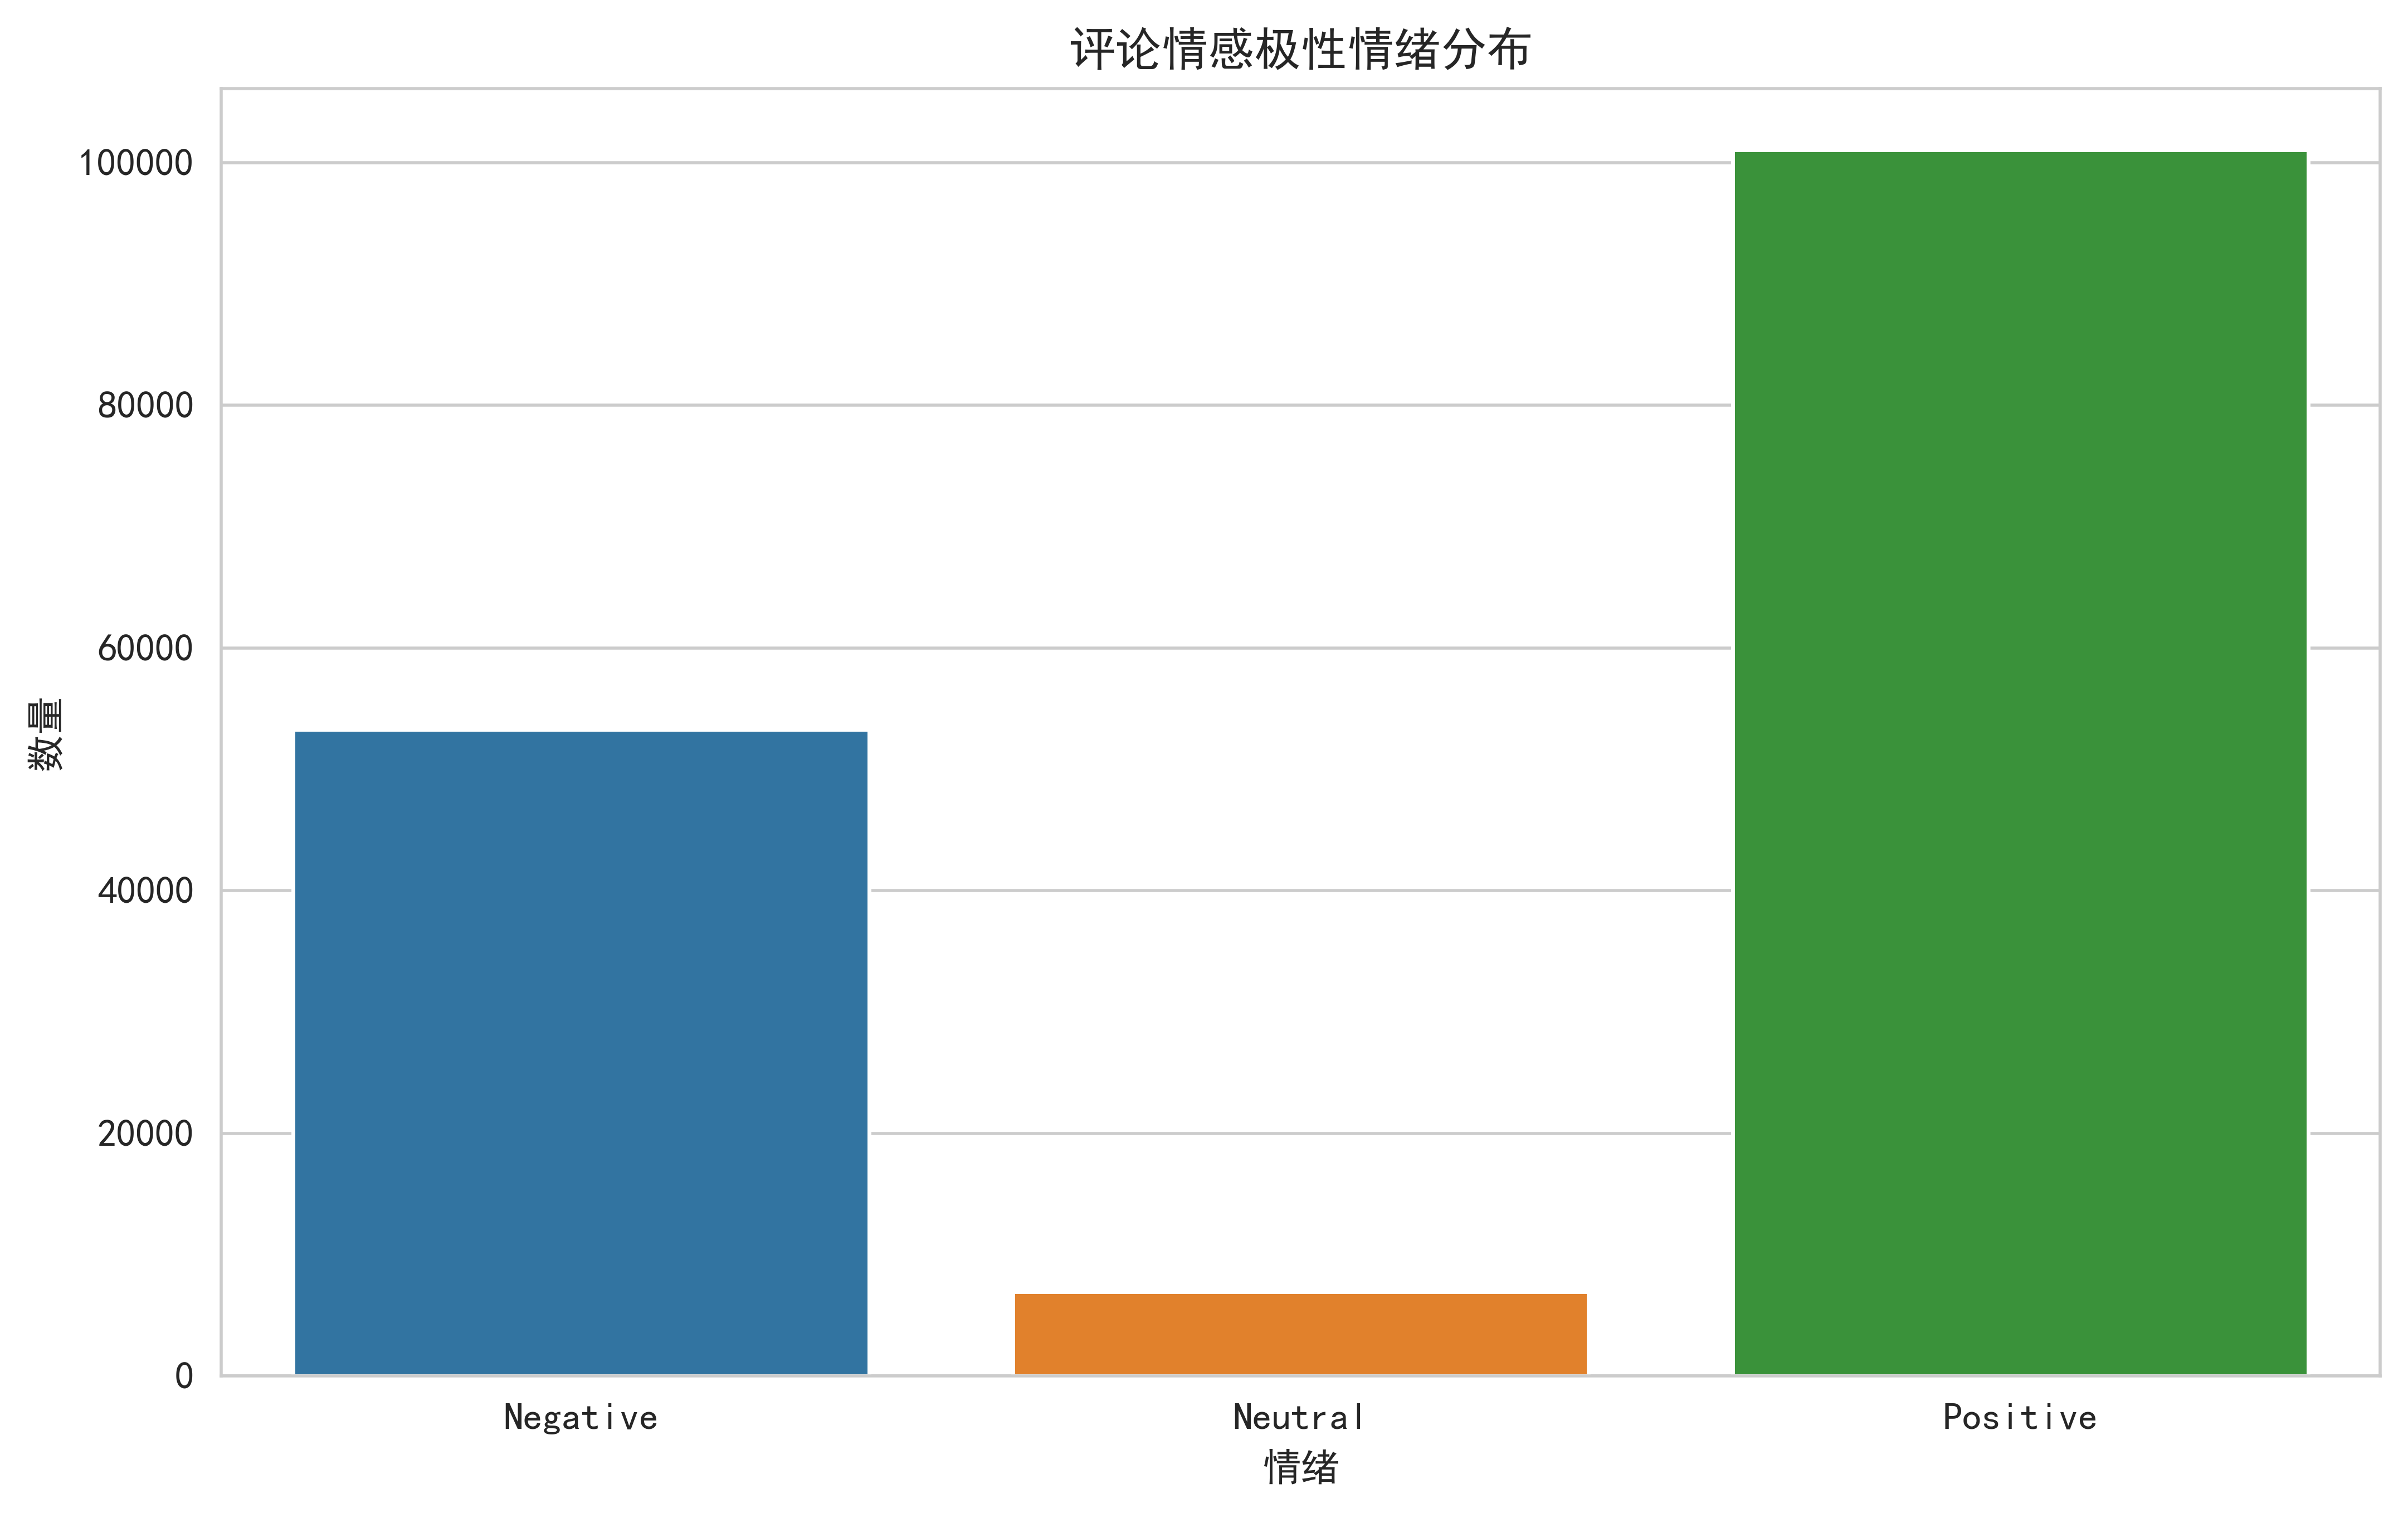

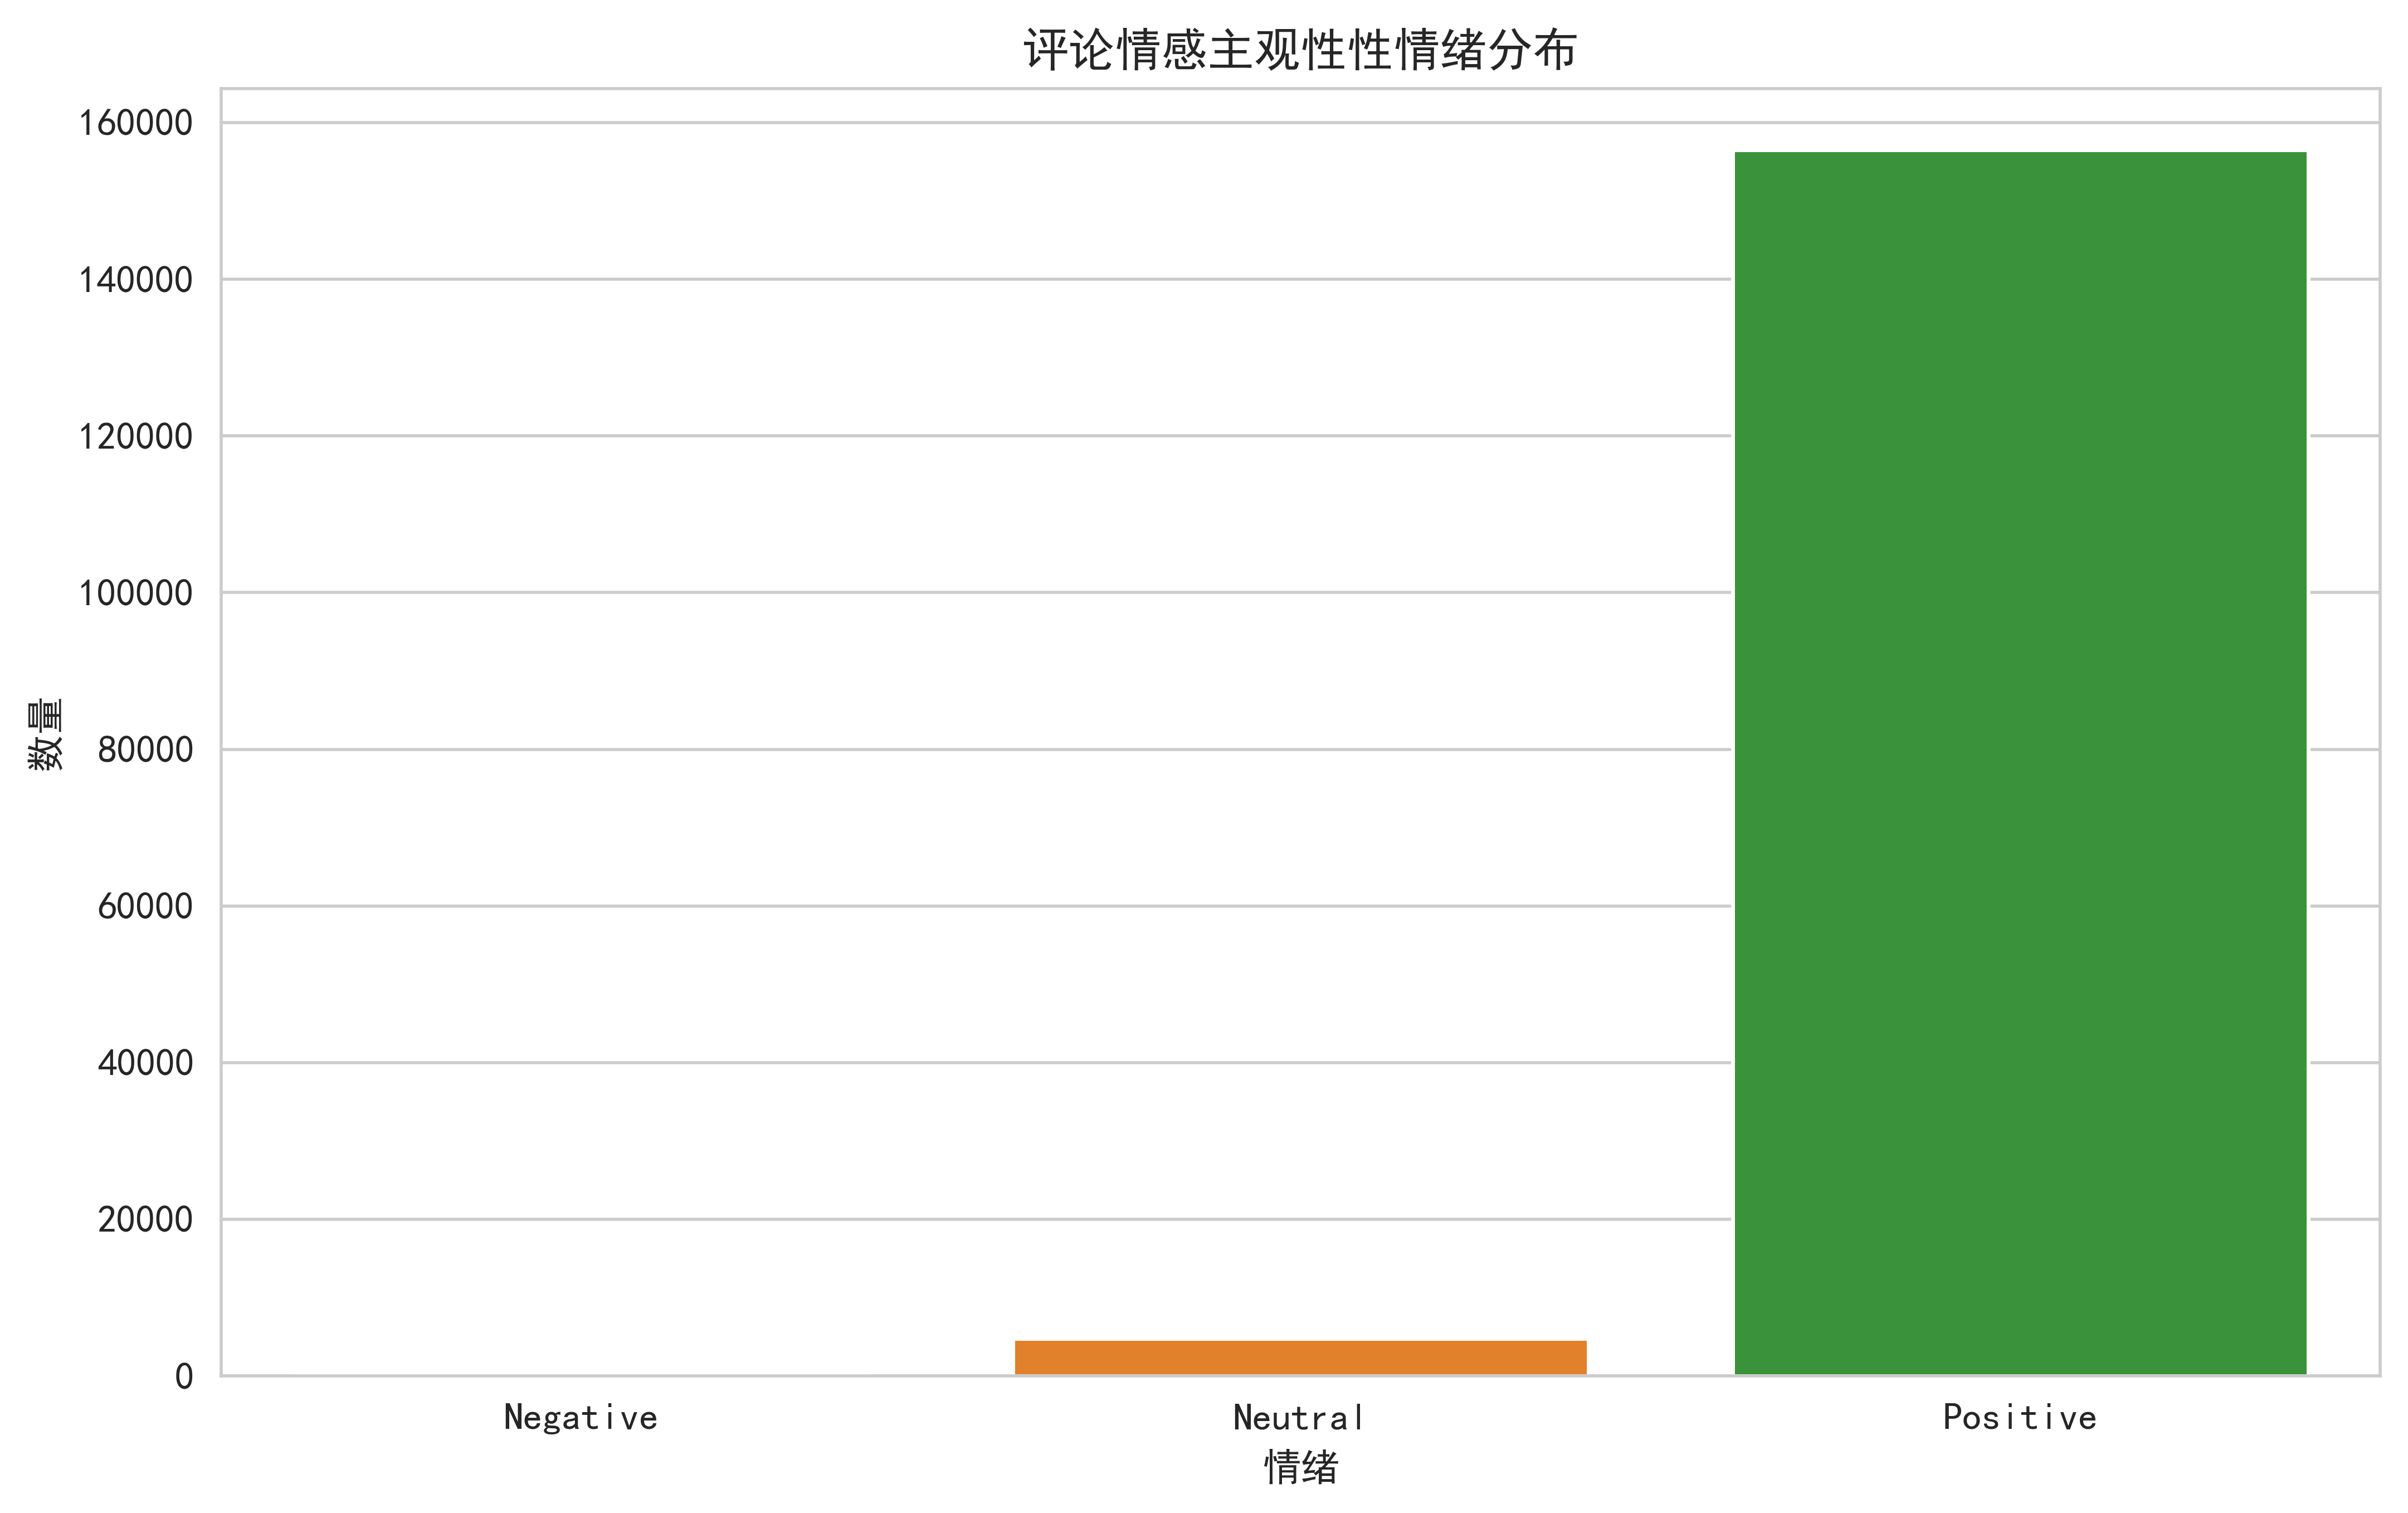

In [126]:
# 定义函数将极性转换为情绪标签
def get_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# 应用函数
train_data['sentiment_1'] = train_data['polarity'].apply(get_sentiment)
train_data['sentiment_2'] = train_data['subjectivity'].apply(get_sentiment)
# 绘制情绪分布图

sns.countplot(x='sentiment_1', data=train_data, order=['Negative', 'Neutral', 'Positive'])
plt.title('评论情感极性情绪分布')
plt.xlabel('情绪')
plt.ylabel('数量')
plt.show()

sns.countplot(x='sentiment_2', data=train_data, order=['Negative', 'Neutral', 'Positive'])
plt.title('评论情感主观性性情绪分布')
plt.xlabel('情绪')
plt.ylabel('数量')
plt.show()


In [111]:
nltk.download('wordnet')

def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

# 对评论文本进行预处理
processed_reviews = train_data['review'].map(preprocess)

# 显示前5个预处理后的评论
for i in range(10):
    print(processed_reviews[i])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['effect', 'combin', 'bystol', 'fish']
['halfway', 'fourth', 'week', 'intuniv', 'concern', 'begin', 'week', 'start', 'take', 'highest', 'dose', 'day', 'hard', 'cranki', 'sleep', 'near', 'hour', 'drive', 'home', 'school', 'vacat', 'unusu', 'call', 'doctor', 'monday', 'morn', 'say', 'stick', 'day', 'school', 'get', 'morn', 'day', 'problem', 'free', 'agreeabl', 'emot', 'good', 'thing', 'cranki', 'rememb', 'thing', 'overal', 'behavior', 'better', 'tri', 'differ', 'medic', 'effect']
['oral', 'contracept', 'pill', 'cycl', 'happi', 'light', 'period', 'day', 'effect', 'contain', 'hormon', 'gestoden', 'avail', 'switch', 'lybrel', 'ingredi', 'similar', 'pill', 'end', 'start', 'lybrel', 'immedi', 'period', 'instruct', 'say', 'period', 'last', 'week', 'take', 'second', 'pack', 'week', 'pack', 'thing', 'wors', 'period', 'last', 'week', 'week', 'daili', 'brown', 'discharg', 'posit', 'effect', 'idea', 'period', 'free', 'tempt', 'ala']
['time', 'form', 'birth', 'control', 'glad', 'go', 'patch', 'month

In [112]:

# 创建词典
dictionary = corpora.Dictionary(processed_reviews)

# 创建语料库
corpus = [dictionary.doc2bow(text) for text in processed_reviews]

# 创建LDA模型
lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

# 打印10个主题
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    print('\n')

Topic: 0 
Words: 0.053*"sleep" + 0.035*"night" + 0.026*"take" + 0.022*"work" + 0.020*"quot" + 0.017*"help" + 0.014*"hour" + 0.014*"wake" + 0.014*"time" + 0.013*"feel"


Topic: 1 
Words: 0.022*"take" + 0.022*"drink" + 0.018*"work" + 0.016*"water" + 0.013*"time" + 0.013*"hour" + 0.013*"tast" + 0.011*"go" + 0.011*"dose" + 0.009*"like"


Topic: 2 
Words: 0.049*"take" + 0.027*"day" + 0.024*"feel" + 0.023*"pill" + 0.019*"effect" + 0.018*"pain" + 0.017*"hour" + 0.017*"week" + 0.017*"go" + 0.016*"start"


Topic: 3 
Words: 0.021*"feel" + 0.021*"anxieti" + 0.018*"depress" + 0.018*"take" + 0.018*"start" + 0.017*"effect" + 0.017*"week" + 0.015*"year" + 0.014*"work" + 0.013*"life"


Topic: 4 
Words: 0.026*"blood" + 0.024*"year" + 0.023*"effect" + 0.016*"pressur" + 0.016*"week" + 0.016*"smoke" + 0.015*"take" + 0.013*"heart" + 0.012*"quit" + 0.012*"month"


Topic: 5 
Words: 0.030*"month" + 0.025*"shoot" + 0.017*"year" + 0.016*"start" + 0.016*"week" + 0.015*"doctor" + 0.014*"infect" + 0.013*"go" + 0.0

In [128]:
# 获取主题
topics = lda_model.print_topics(-1)

# 创建5x2的组图
fig, axes = plt.subplots(5, 2, figsize=(17.18, 21), dpi = 500 )
axes = axes.flatten()

# 绘制每个主题的关键词权重
for idx, ax in enumerate(axes):
    topic = dict((word, prob) for word, prob in lda_model.show_topic(idx))
    words = list(topic.keys())
    probs = list(topic.values())
    ax.bar(words, probs)
    ax.set_title('Topic: {}'.format(idx))
    ax.set_xlabel('Words')
    ax.set_ylabel('Probability')

plt.tight_layout()
plt.show()

In [123]:
# 计算每种药物的平均评级、情感极性和主观性
drug_profiles = train_data.groupby('drugName').agg({'rating': 'mean', 'polarity': 'mean', 'subjectivity': 'mean'})

# 显示前5行数据
drug_profiles.head()

rating  polarity  subjectivity
drugName                                                               
A + D Cracked Skin Relief             10.000000  0.284722      0.640278
A / B Otic                            10.000000  0.287500      0.500000
Abacavir / dolutegravir / lamivudine   8.211538  0.089788      0.484149
Abacavir / lamivudine / zidovudine     9.000000 -0.055556      0.088889
Abatacept                              7.157895  0.092637      0.504336

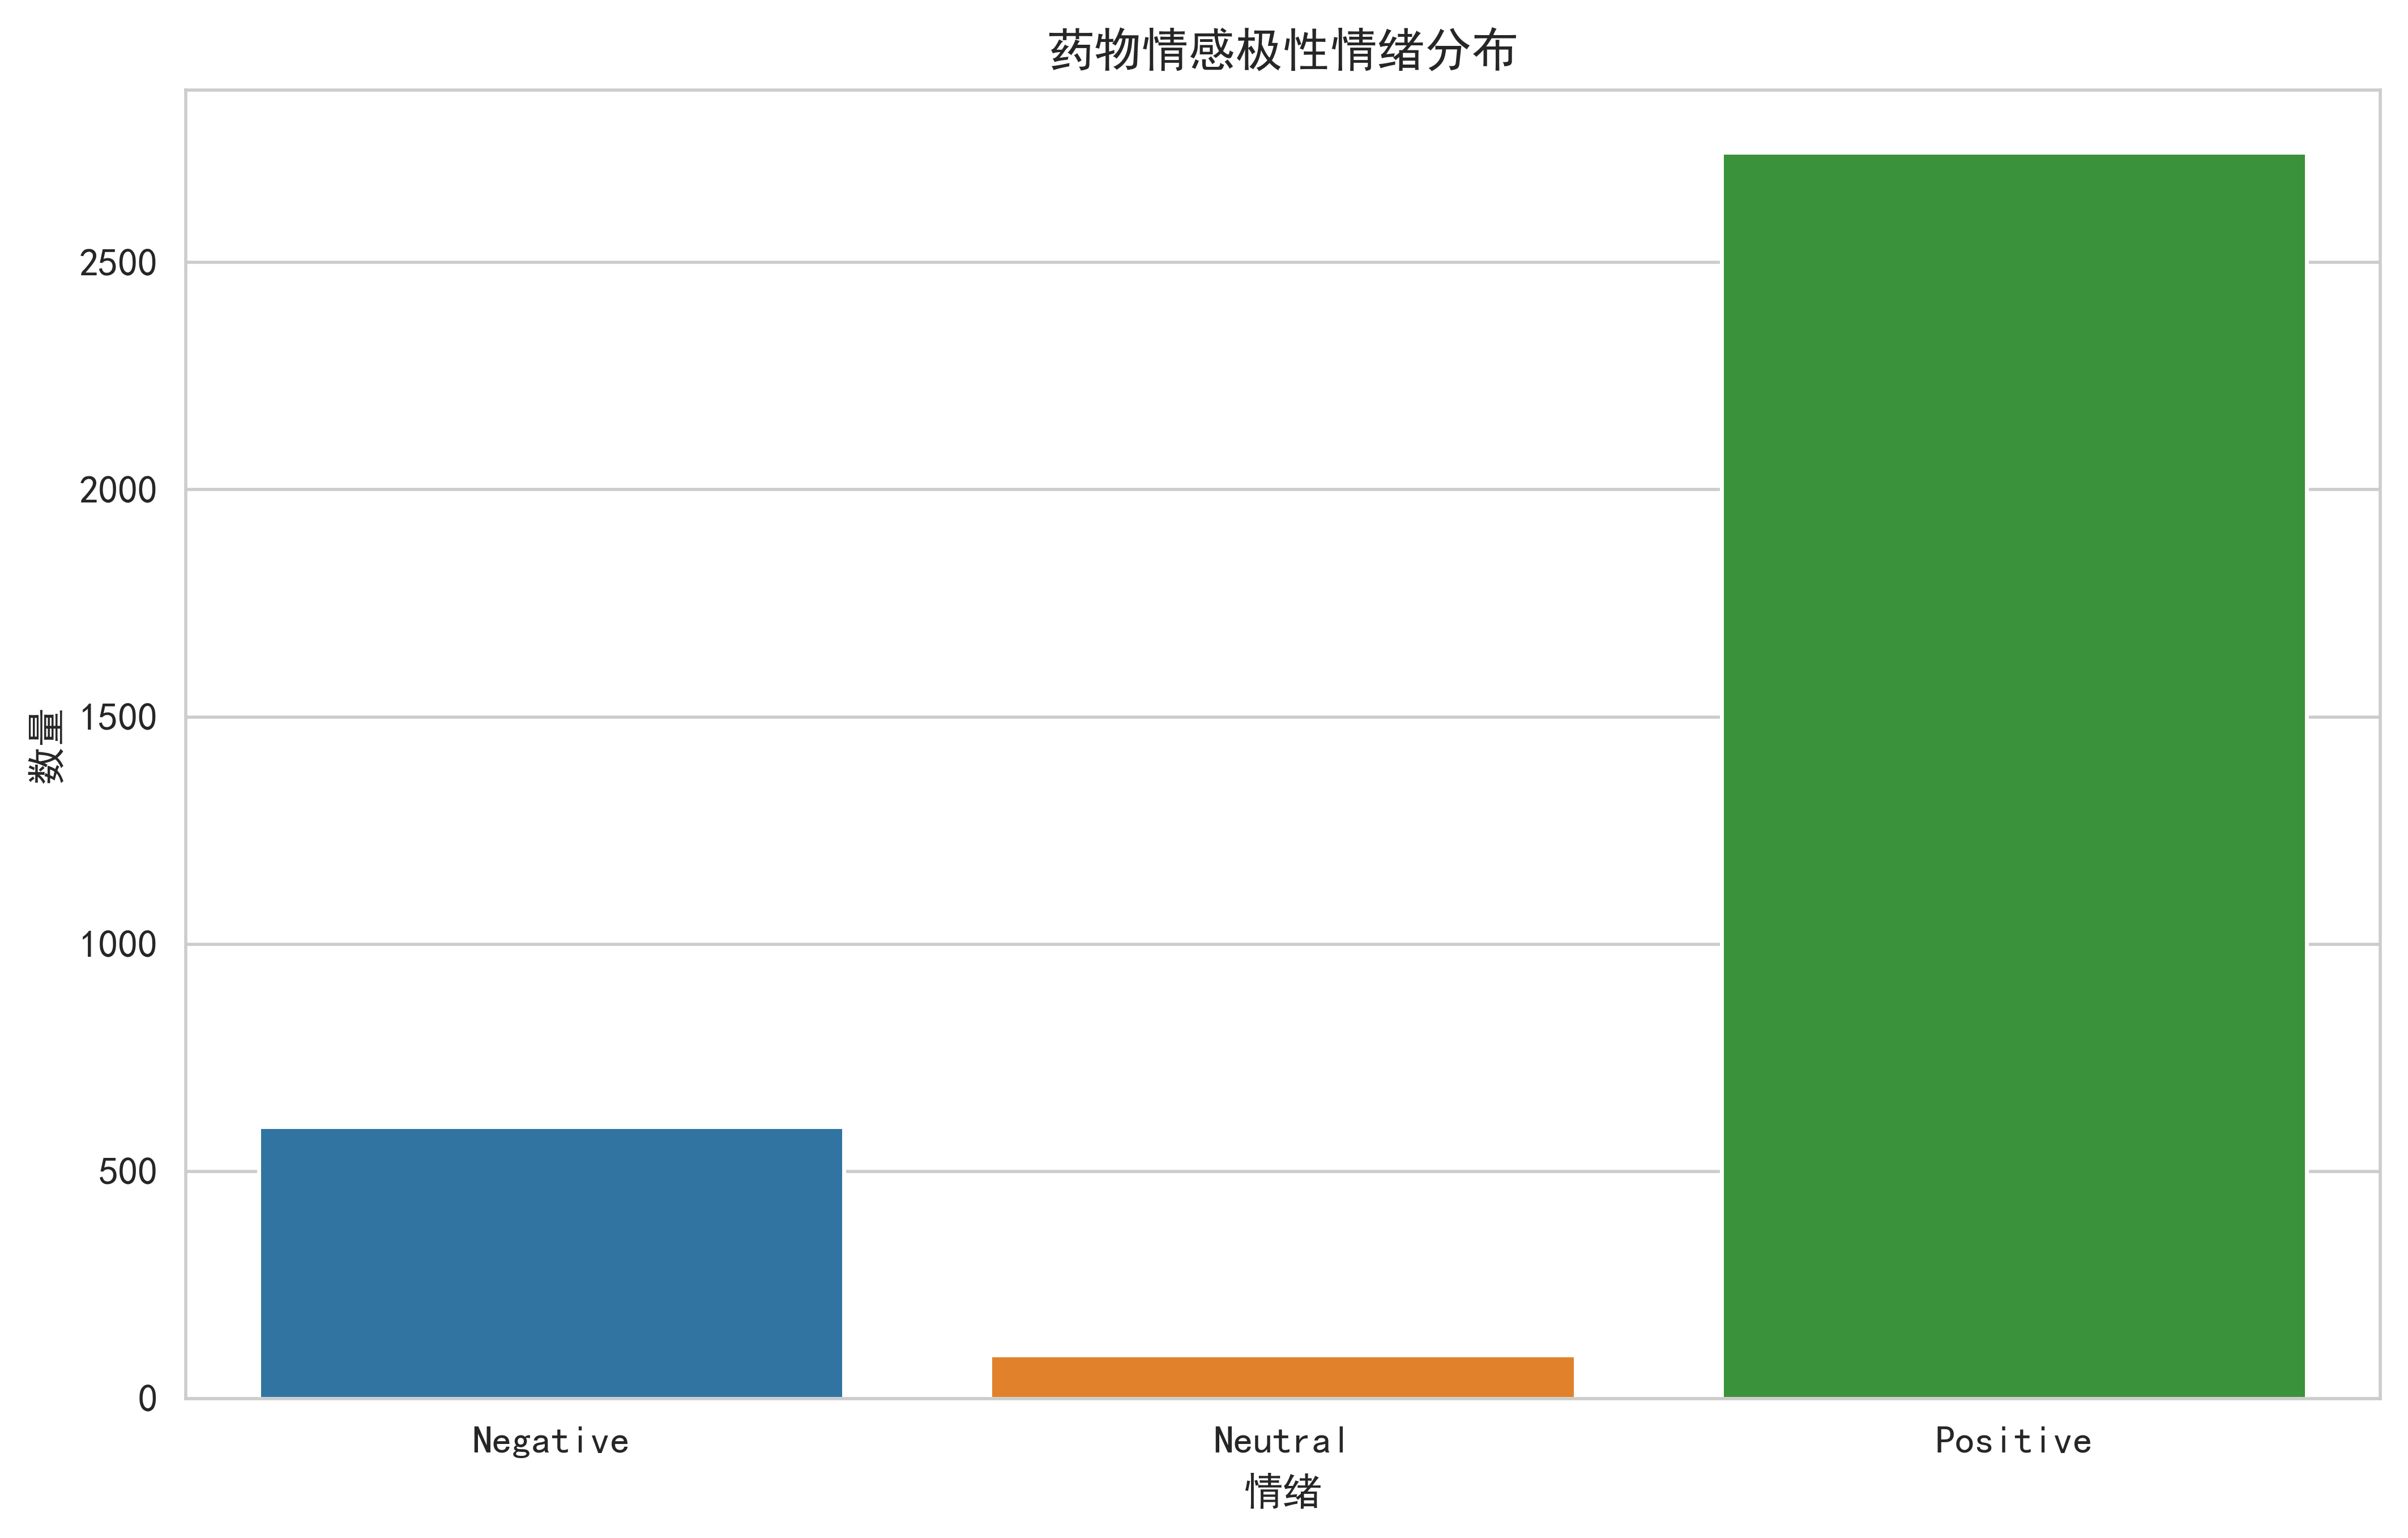

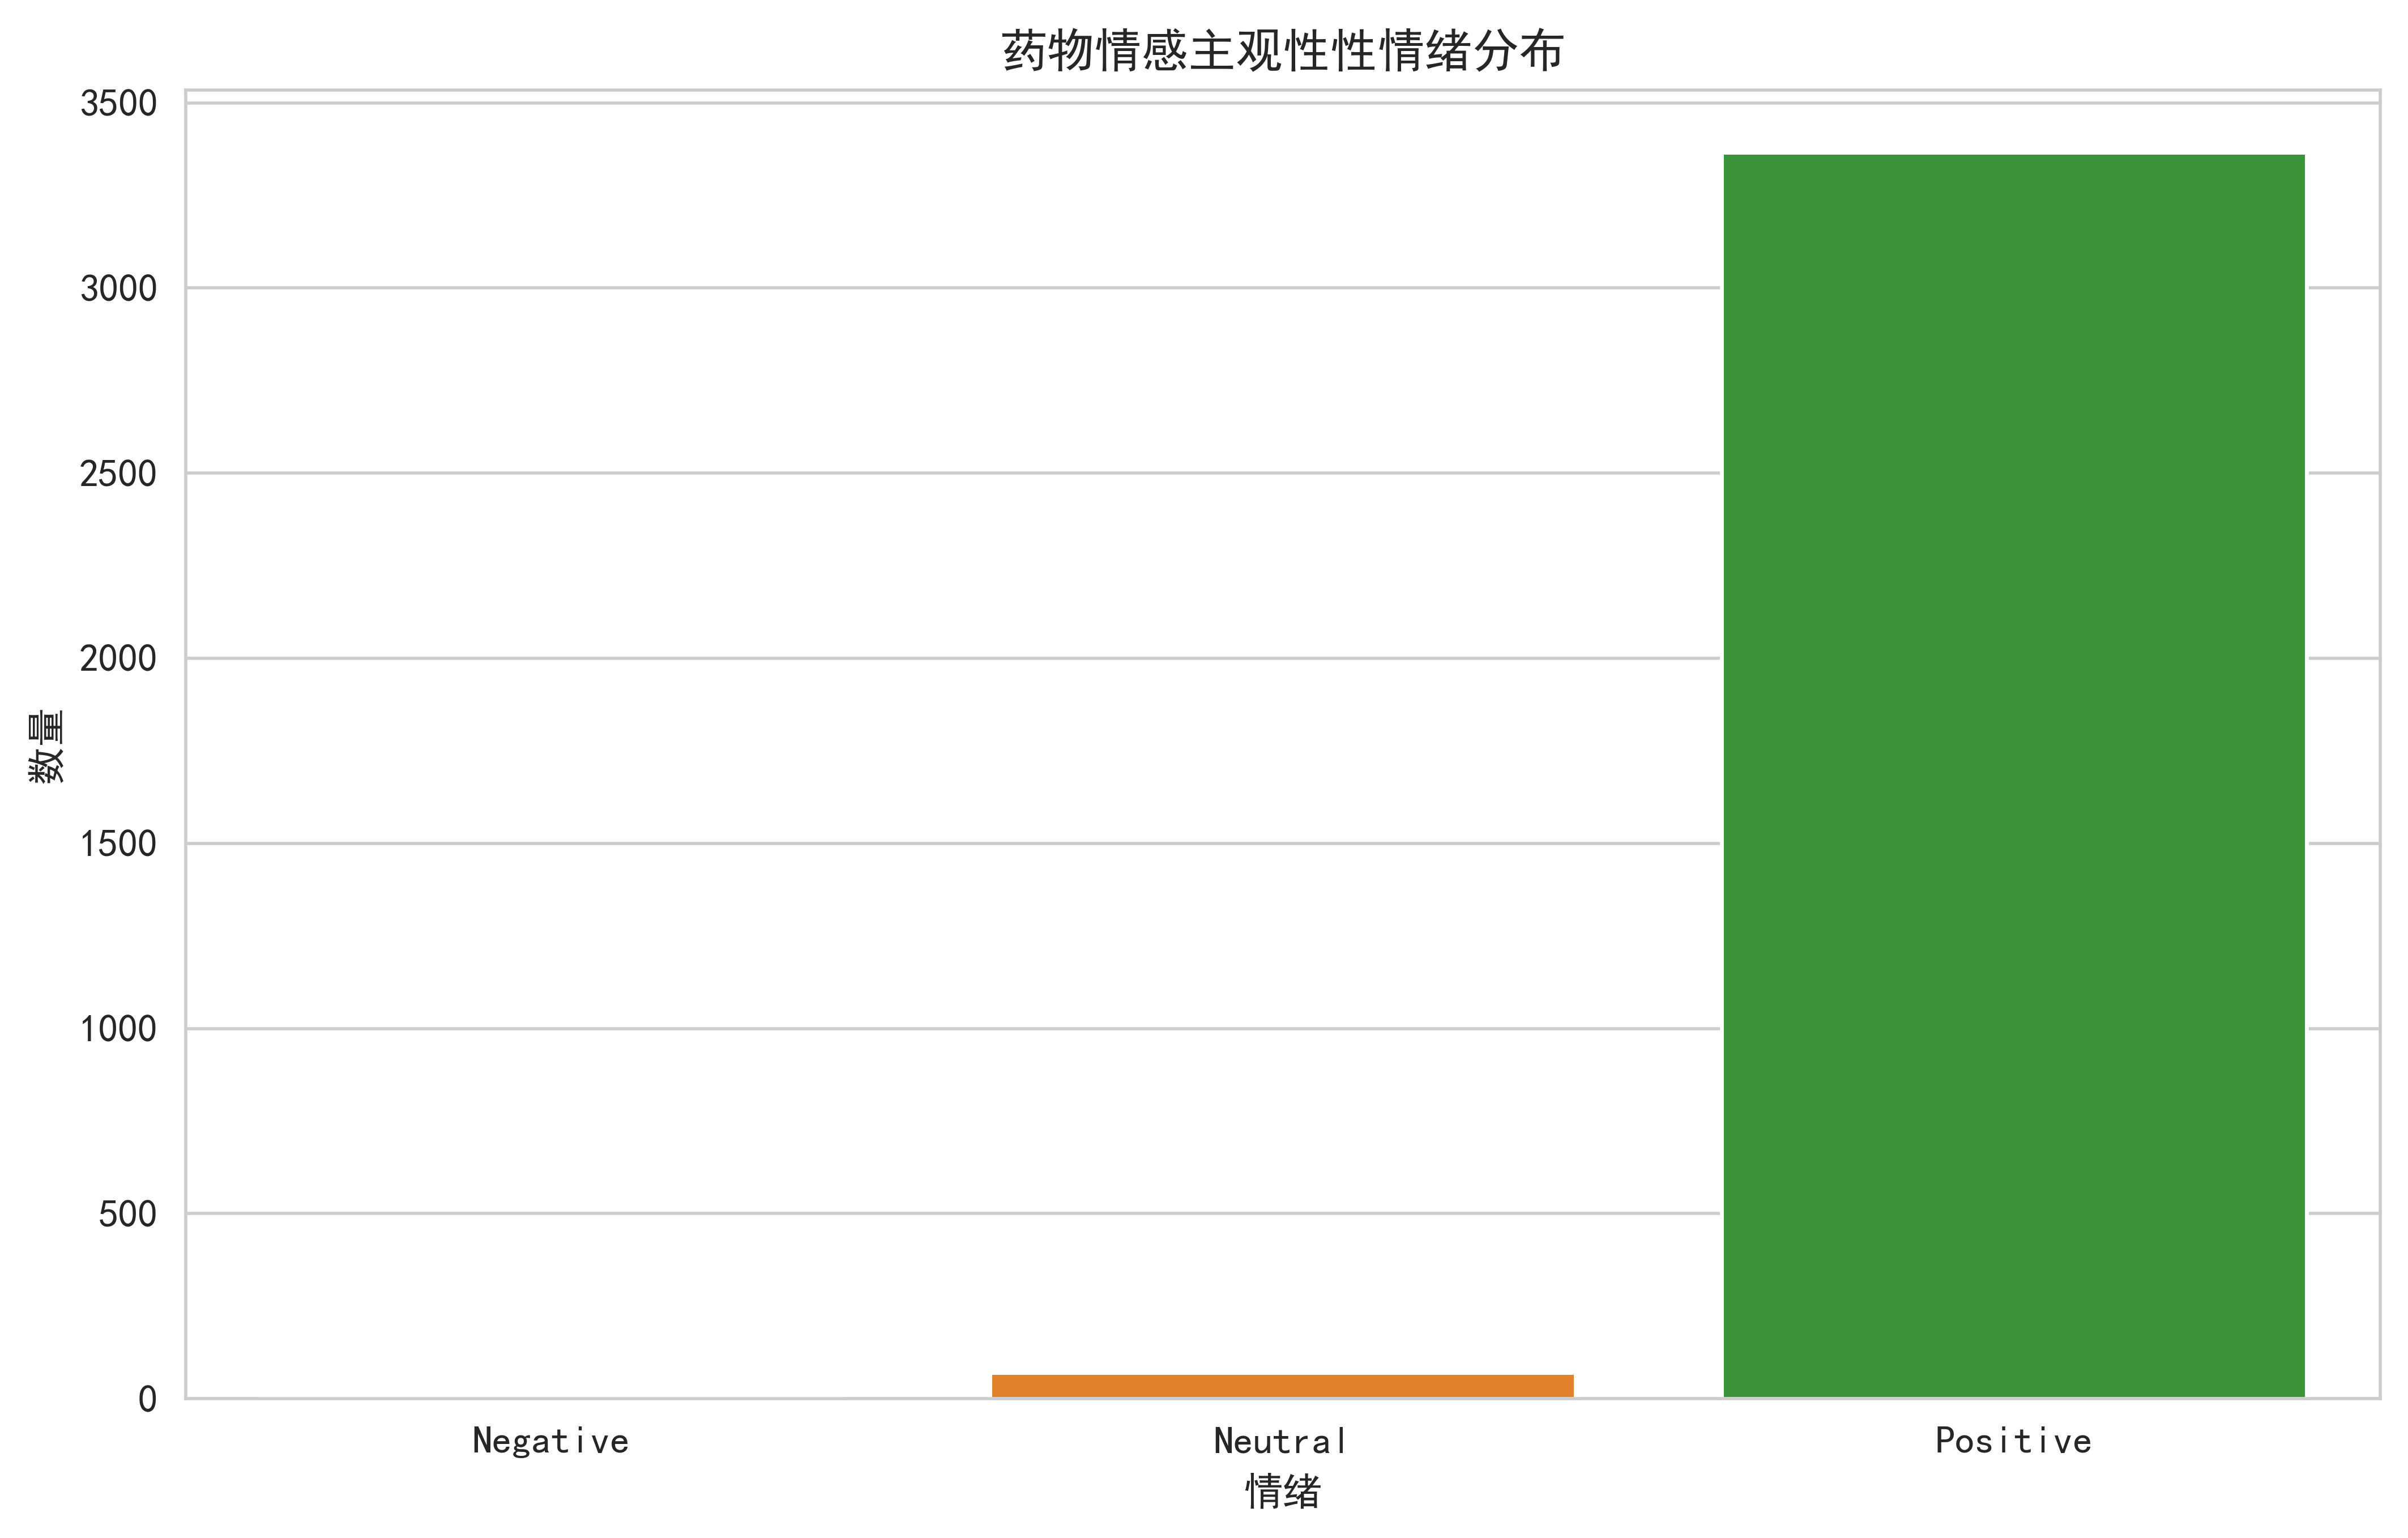

In [125]:
# 应用函数
drug_profiles['sentiment_1'] = drug_profiles['polarity'].apply(get_sentiment)
drug_profiles['sentiment_2'] = drug_profiles['subjectivity'].apply(get_sentiment)

# 绘制情绪分布图

sns.countplot(x='sentiment_1', data=drug_profiles, order=['Negative', 'Neutral', 'Positive'])
plt.title('药物情感极性情绪分布')
plt.xlabel('情绪')
plt.ylabel('数量')
plt.show()

sns.countplot(x='sentiment_2', data=drug_profiles, order=['Negative', 'Neutral', 'Positive'])
plt.title('药物情感主观性性情绪分布')
plt.xlabel('情绪')
plt.ylabel('数量')
plt.show()



In [115]:

# 创建TF-IDF向量化器
vectorizer = TfidfVectorizer()

# 计算TF-IDF向量
tfidf_matrix = vectorizer.fit_transform(train_data['review'])

# 打印TF-IDF矩阵的形状
print(tfidf_matrix.shape)

(161297, 49899)


In [116]:


# 创建一个TruncatedSVD实例：svd
svd = TruncatedSVD(n_components=50)

# 创建一个KMeans实例：kmeans
kmeans = KMeans(n_clusters=5)

# 创建一个管道：pipeline
pipeline = make_pipeline(svd, kmeans)

# 训练模型
pipeline.fit(tfidf_matrix)

# 计算聚类标签
labels = pipeline.predict(tfidf_matrix)

# 添加聚类标签到原始数据集
train_data['cluster'] = labels

# 显示每个聚类的药物数量
print(train_data.groupby('cluster')['drugName'].nunique())

/root/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster
0    1526
1    1212
2    3081
3    2156
4     290
Name: drugName, dtype: int64


In [117]:
# 计算每个聚类中的主要药物
top_drugs_in_clusters = train_data.groupby('cluster')['drugName'].apply(lambda x: x.value_counts().index[0])
print('每个聚类中的主要药物:')
print(top_drugs_in_clusters)

# 计算每个聚类中药物的评级、情感极性和主观性的平均值
cluster_profiles = train_data.groupby('cluster').agg({'rating': 'mean', 'polarity': 'mean', 'subjectivity': 'mean'})
print('\n每个聚类中药物的评级、情感极性和主观性的平均值:')
print(cluster_profiles)

每个聚类中的主要药物:
cluster
0    Etonogestrel
1        Tramadol
2     Phentermine
3    Escitalopram
4    Etonogestrel
Name: drugName, dtype: object

每个聚类中药物的评级、情感极性和主观性的平均值:
           rating  polarity  subjectivity
cluster                                  
0        7.009142  0.061392      0.519973
1        7.051834  0.064740      0.474707
2        7.161587  0.099006      0.492000
3        7.081637  0.049574      0.495433
4        6.431456  0.036381      0.516575


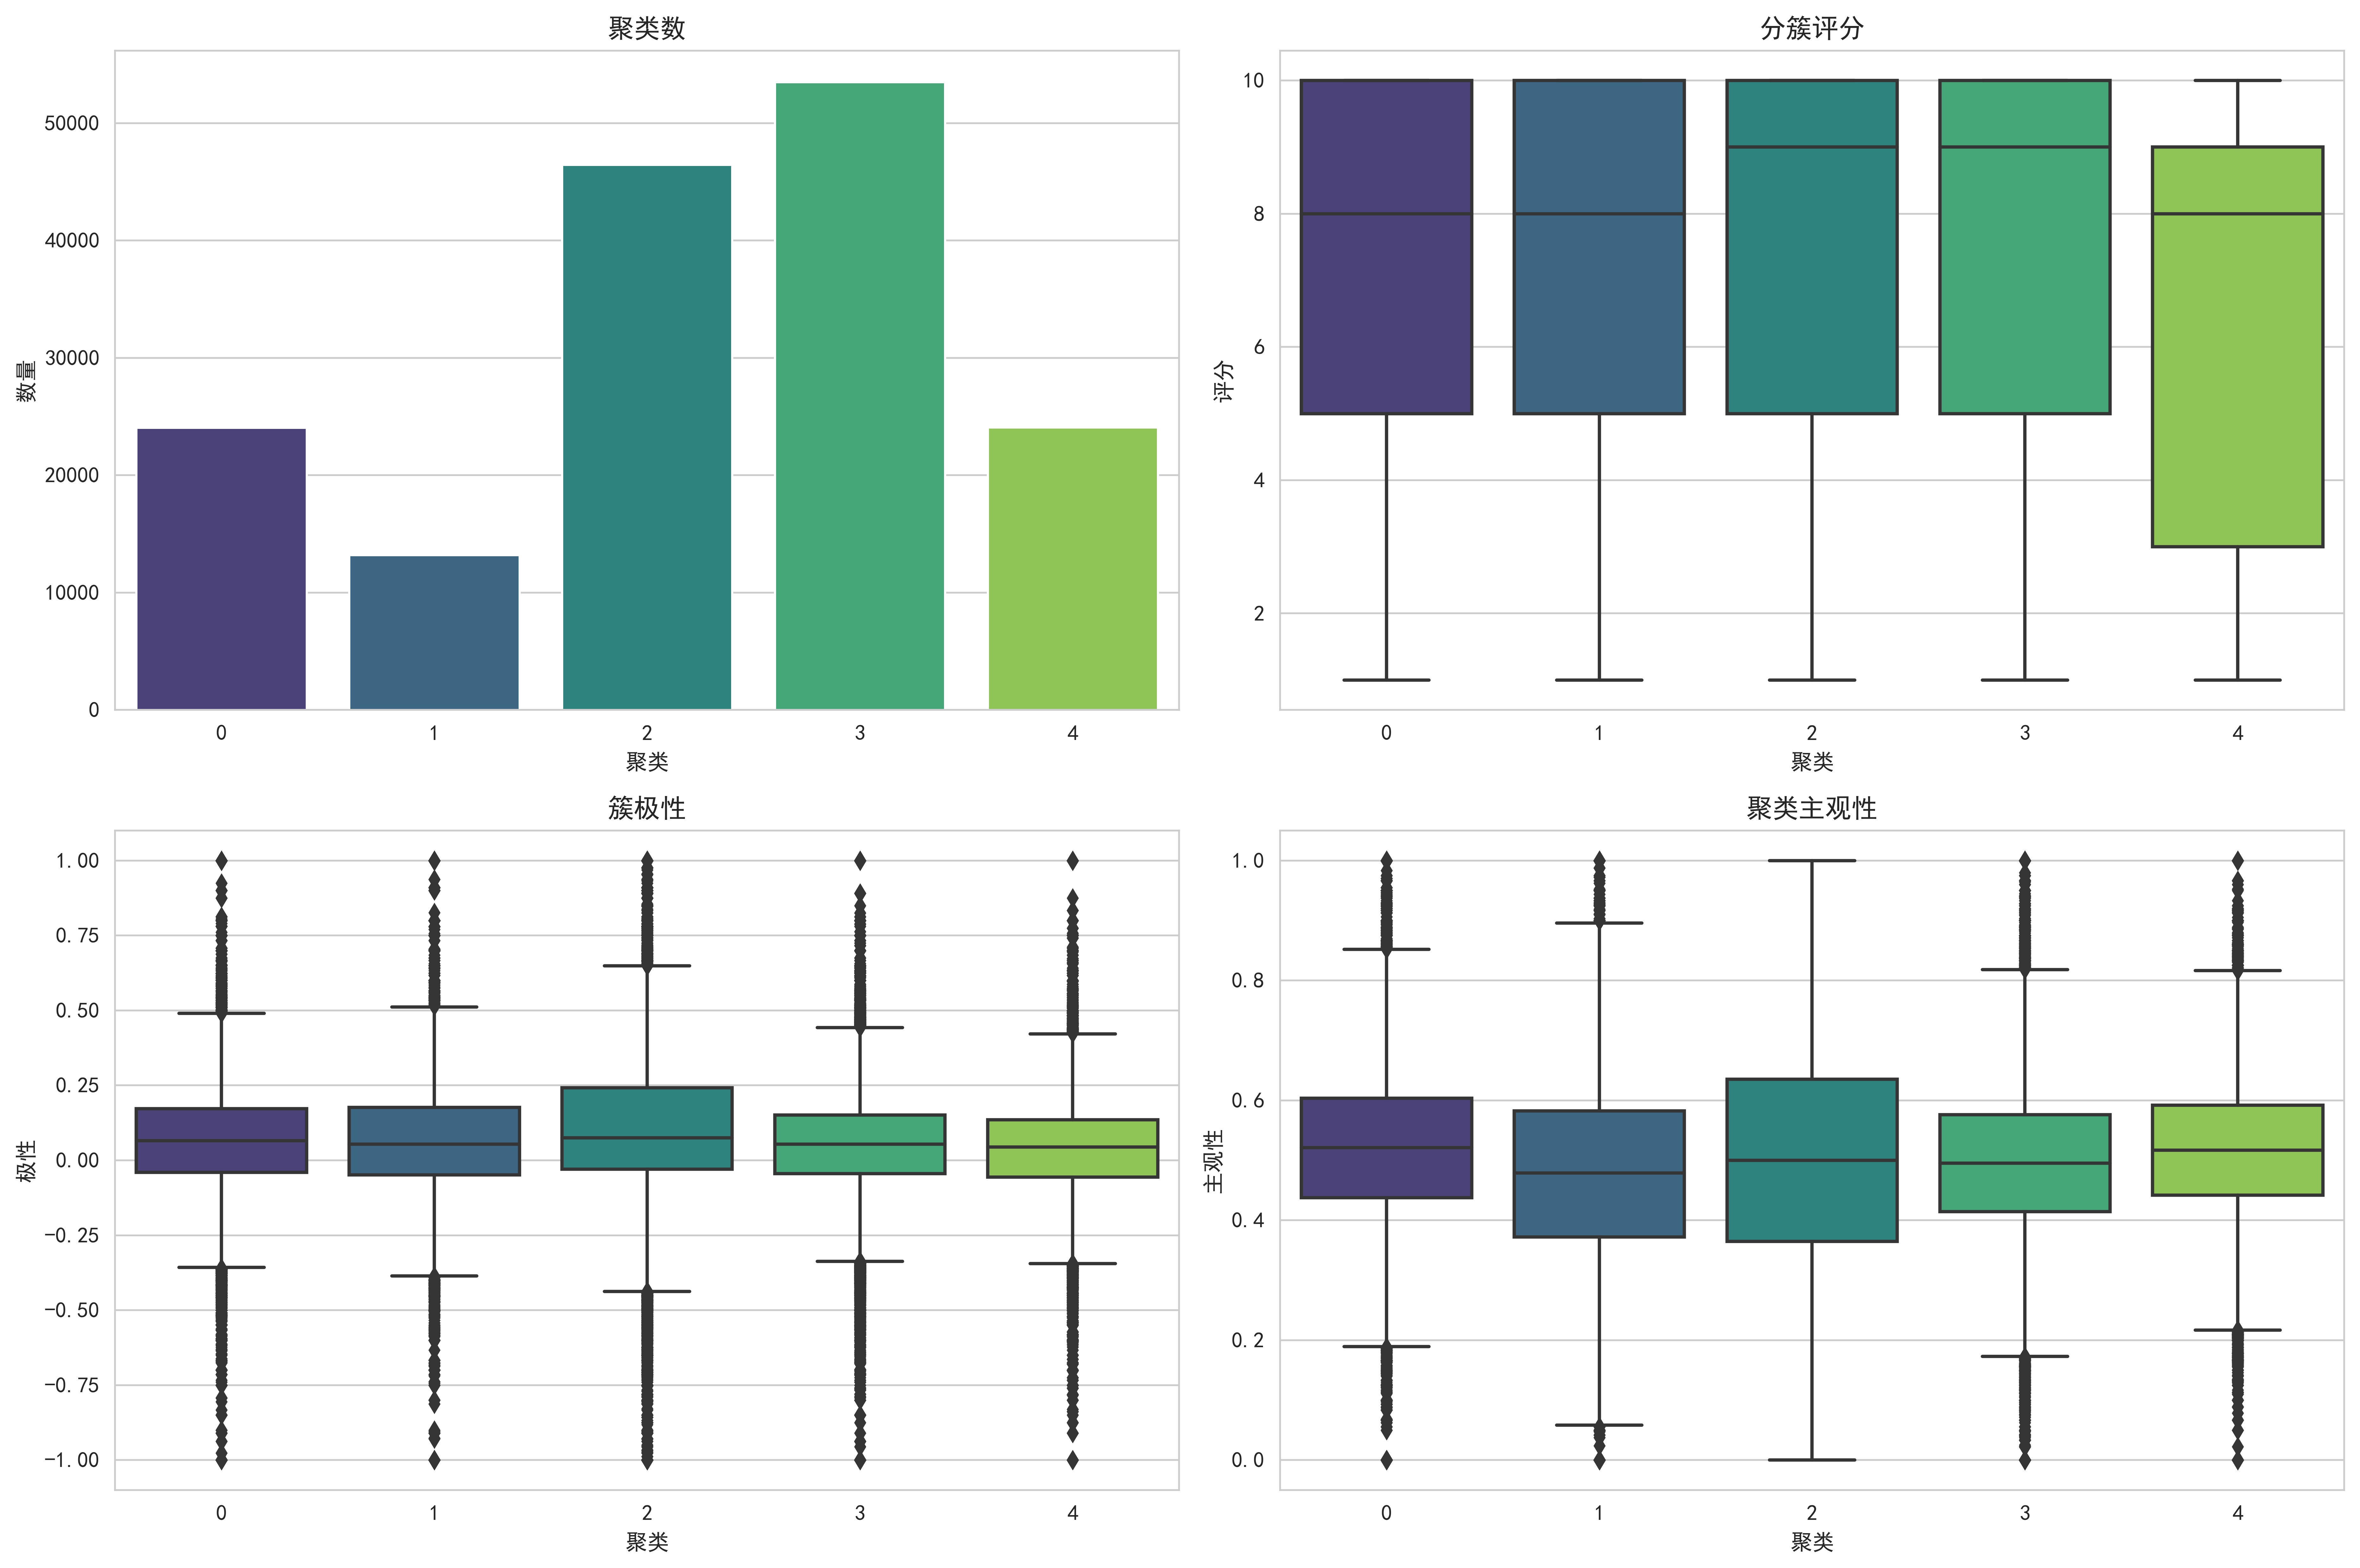

In [130]:

# Set the style of the visualization
# sns.set(style="whitegrid")

# Create a count plot of clusters

fig, axs = plt.subplots(2, 2, figsize=(15, 10) ,dpi=500)

# Create a countplot for clusters
sns.countplot(x='cluster', data=train_data, palette='viridis', ax=axs[0, 0])
axs[0, 0].set_title('聚类数')
axs[0, 0].set_xlabel('聚类')
axs[0, 0].set_ylabel('数量')

# Create a boxplot for rating by cluster
sns.boxplot(x='cluster', y='rating', data=train_data, palette='viridis', ax=axs[0, 1])
axs[0, 1].set_title('分簇评分')
axs[0, 1].set_xlabel('聚类')
axs[0, 1].set_ylabel('评分')

# Create a boxplot for polarity by cluster
sns.boxplot(x='cluster', y='polarity', data=train_data, palette='viridis', ax=axs[1, 0])
axs[1, 0].set_title('簇极性')
axs[1, 0].set_xlabel('聚类')
axs[1, 0].set_ylabel('极性')

# Create a boxplot for subjectivity by cluster
sns.boxplot(x='cluster', y='subjectivity', data=train_data, palette='viridis', ax=axs[1, 1])
axs[1, 1].set_title('聚类主观性')
axs[1, 1].set_xlabel('聚类')
axs[1, 1].set_ylabel('主观性')

plt.tight_layout()
plt.show()


In [119]:

# 选择需要的特征
features = ['polarity', 'subjectivity']
target = 'rating'

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(train_data[features], train_data[target], test_size=0.2, random_state=42)

# 创建线性回归模型
reg = LinearRegression()

# 训练模型
reg.fit(X_train, y_train)

# 预测测试集
y_pred = reg.predict(X_test)

# 计算均方误差和R^2得分
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(9.347257020929492, 0.12284094674126245)